# **Práctica Final Reconocimiento de Formas**

* **Alumno 1**: Bolinches Segovia, Jorge
* **Alumno 2**: Cerezo Pomykol, Jan

**Nota**: El alumno *Cercadillo Muñoz, Daniel*, que figura como autor en las anteriores entregas, sin haber participado en la elaboración de ninguna de ellas, nos ha confirmado oficialmente que ha abandonado la asignatura, por tanto no consta como autor en esta práctica.

# **Introducción**

Este notebook de Jupyter contiene las soluciones propuestas a los apartados del enunciado de la práctica correspondiente a la primera parte de la asignatura. Incluye tanto la implementación de los clasificadores como las pruebas realizadas con estos. A continuación se explica brevemente el procedimiento seguido para implementar cada clasificador, así como los métodos de reducción de la dimensionalidad vistos en clase, y que se emplean más adelante:

***

#### **Clasificador distancia euclídea:**
Este clasificador asigna datos según la distancia mínima a los centroides de cada clase.

El entrenamiento de este clasificador consiste en calcular los centroides $z_{i}$ de cada clase. Esto es lo que hace la función `fit` del clasificador.

$$z_{i} = \frac{1}{card(\alpha_{i})}\sum\limits _{\forall x\in\alpha_{i}}x$$

La predicción consiste en calcular la distancia euclídea de cada vector de entrada a los centroides de cada clase y elegir la clase que se corresponde con la menor distancia euclídea asociada. El cálculo de pertenencia se hace con `decision_function`. La función de pertenencia es la siguiente:

$$ de_{i}(x) \equiv D_{E}(x, z_{i}) = \sqrt{\sum\limits_{j=0}^{n}(x_{j}-z_{i})^{2}}$$

Donde $D_{E}(x, z_{i})$ es la distancia eculídea de $x$ al centroide $z_{i}$ y $n$ es la dimensión de cada dato. Dado que esta función proporciona la distancia a una clase, se selecciona el valor mínimo de las distancias a cada clase. Se asigna el elemento $x$ a la clase $\alpha_{i}$ si:

$$ i = \arg\min_{j}\{de_{i}(x)\} $$

Esta operación se ejecuta en la función `predict`.

***

#### **Clasificador estadístico bayesiano:**

Este clasificador parte de la hipótesis de distribución gaussiana. La función de pertenencia del clasificador es la siguiente:

$$ db_{i}(x) = -\frac{1}{2}ln|\Sigma_{i}|-\frac{1}{2}(x-\mu_{i})^{T}\Sigma_{i}^{-1}(x-\mu_{i})+\ln P(\alpha_{i})$$

Donde $\Sigma_{i}$ es la matriz de covarianzas de la clase $\alpha_{i}$, $P(\alpha_{i})$ es la probabilidad a priori de la clase $\alpha_{i}$, y $\mu_{i}$ es la media de la clase $\alpha_{i}$. Dado que esta función proporciona una probabilidad de pertenencia a una clase, se selecciona el valor máximo. Se asigna el elemento $x$ a la clase $\alpha_{i}$ si:

$$ i = \arg\max_{j}\{db_{i}(x)\} $$

En la implementación se emplea $dbq_{i} = \ln(db_{i}(x))$, que tiene forma cuadrática:

$$ dbq_{i}(x) = x^{T}[-\frac{1}{2}\Sigma_{i}^{-1}]x + [\mu_{i}^{T}\Sigma_{i}^{-1}]x -\frac{1}{2}\mu_{i}^{T}\Sigma_{i}^{-1}\mu_{i} -\frac{1}{2}\ln|\Sigma_{i}| + \ln P(\alpha_{i})$$

En la implementación (`ClassifEstadistico`), los términos $a$, $b$ y $c$ de la expresión cuadrática $ax^{2}+bx+c$ se corresponden con:

$$a = -\frac{1}{2}\Sigma_{i}^{-1}$$

$$b = \mu_{i}^{T}\Sigma_{i}^{-1}$$

$$c = -\frac{1}{2}\mu_{i}^{T}\Sigma_{i}^{-1}\mu_{i} -\frac{1}{2}\ln|\Sigma_{i}| + \ln P(\alpha_{i})$$

Estos términos se calculan en el entrenamiento del clasificador `fit`, dado que son independientes del vector $x$ de entrada a la hora de clasificar. En la función clasificadora (`decision_function`), se calcula $dbq_{i}(x)$. De esta forma se reduce el tiempo de clasificación de nuevos datos, aumentando ligeramente el tiempo de entrenamiento (que sólo se hace una vez).

El clasificador estadístico regularizado añade dos hiperparámetros en el cálculo de la matriz de covarianzas: $\lambda$ y $\gamma$. El primero indica una medida de similitud entre clases, mientras que el segundo sirve para regularizar la matriz de covarianzas. El hiperparámetro $\lambda$ también indica lo parecida o distinta que es la matriz de covarianzas de la clase a la matriz de covarianzas de todos los datos. Primero se calcula la matriz $\Sigma_{i}^{\lambda}$:

$$\Sigma_{i}^{\lambda} = \frac{(1-\lambda)n_{i}\Sigma_{i} + \lambda nS_{w}}{(1-\lambda)n_{i} + \lambda n}$$

Donde $n_{i}$ es el número de representantes de la clase $i$, $n$ es el número total de representantes, y $S_{w}$ es la matriz

$$S_{w} = \sum\limits_{i=0}^{c}\frac{n_{i}}{n}\Sigma_{i}$$

donde $c$ es el número de clases. Esta matriz es una matriz de covarianzas de todas las clases, pero teniendo en cuenta la proporción de datos de cada clase.

A continuación se calcula la matriz $\Sigma_{i}^{\lambda, \gamma}$, que tiene en cuenta el parámetro $\gamma$:

$$\Sigma_{i}^{\lambda, \gamma} = (1-\gamma)\Sigma_{i}^{\lambda} + \gamma c_{i} I_{d}$$

Donde $I_{d}$ es la matriz identidad $d x d$, $d$ la dimensión de cada representante y $c_{i}$ es:

$$c_{i} = \frac{Tr\{\Sigma_{i}^{\lambda}\}}{d}$$

Con la nueva matriz de covarianzas $\Sigma_{i}^{\lambda, \gamma}$ se obtiene $dbrq_{i}(x)$: 

$$ dbrq_{i}(x) = x^{T}[-\frac{1}{2}\Sigma_{i}^{\lambda, \gamma -1}]x + [\mu_{i}^{T}\Sigma_{i}^{\lambda, \gamma -1}]x -\frac{1}{2}\mu_{i}^{T}\Sigma_{i}^{\lambda, \gamma -1}\mu_{i} -\frac{1}{2}\ln|\Sigma_{i}^{\lambda, \gamma}| + \ln P(\alpha_{i})$$

La función de pertenencia sigue siendo la misma: se asigna el elemento $x$ a la clase $\alpha_{i}$ si:

$$ i = \arg\max_{j}\{dbrq_{i}(x)\} $$

***

En la sección de implementaciones se incluyen las implemetanciones de los siguientes clasificadores:
* **Clasificador de la distancia euclídea**: implementado con la función $de_{i}(x)$. Está disponible en la clase `ClassifEuclid`.
* **Clasificador estadístico sin regularizar:** implementado con la función $dbq_{i}(x)$. Está disponible en la clase `ClassifEstadistico`.
* **Clasificador estadístico regularizado:** implementado con la función $dbrq_{i}(x)$. Está disponible en la clase `ClassifEstadisticoRegularizado_metodo_clase`.
* **Clasificador estadístico regularizado (método de sklearn):** implementado con regularización por autovectores. Está disponible en la clase `ClassifEstadisticoRegularizado_metodo_sklearn`. Este clasificador está basado en la solución por *singular value decomposition*. Esto supone que la matriz de covarianzas $\Sigma_{i}$ es igual a $\frac{1}{n-1}X^{T}X = \frac{1}{n-1}VS^{2}V^{T}$. Donde $V$ proviene de la descomposición de valores singulares de $\Sigma_{i} = USV^{T}$. Con esto es posible calcular los valores de pertenencia a cada clase sin tener que calcular explícitamente $\Sigma_{i}^{-1}$, evitando así los errores al intentar invertir una matriz no inversible. Este procedimiento se explica [aquí](https://scikit-learn.org/stable/modules/lda_qda.html#estimation-algorithms). El motivo por el que hemos implementado esta versión es porque con el método de regularización que hemos visto en clase no es posible probar todos los valores de hiperparámetros. Cuando se intenta probar un hiperparámetro que no elimina la singularidad de la matriz de covarianzas, aparecen errores por intentar invertir una matriz no inversible. La solución que hemos tomado para que no aparezcan errores es la siguiente. Cuando se calcula el determinante de la matriz de covarianzas y da 0, entonces 

***

#### **Técnicas de reducción de la dimensionalidad empleadas:**

##### **Análisis de Componentes Principales:**

Este método tiene como objetivo eliminar características muy poco discriminantes de un conjunto de datos, de forma que se conserva la mayoría de la información necesaria para la decisión, eliminando un número considerable de información poco relevante. Esta técnica se puede emplear en múltiples campos, pero detallaremos el procedimiento para esta práctica.

Partiendo de un conjunto de datos $X$ que contiene dimensiones que no aportan información dado que la varianza de esa dimensión es muy pequeña, el Análisis de Componentes Principales consiste en escoger las componentes asociadas a las varianzas más altas de cada una de las dimensiones. Dicho de otra forma, es un método de selección de componentes que maximiza la varianza dentro de cada clase.

1. El primer paso consiste en calcular la media del vector $X$ de datos.

$$\bar X = \frac{1}{m}\sum\limits_{i=1}^{m}X_{i}$$

2. El segundo paso consiste en estandarizar el conjunto de datos. Para ello se resta al vector $X$ su media $\bar X$.

$$\hat X = X - \bar X$$

3. Se calcula la matriz de covarianzas $\Sigma_{\hat X}$ de $\hat X$.

4. Se calcula la descomposición espectral de la matriz $\Sigma_{\hat X}$. Los autovalores ordenados de mayor a menor, proporcionan los autovectores correspondientes a las direcciones de máxima varianza del conjunto de datos (se maximiza $\Sigma_{\hat X}$). En este punto es posible entender por qué es importante estandarizar los datos (paso 2), veamos un ejemplo. Imaginemos que queremos clasificar personas según su salario anual y el número de días que trabajan al año. Supongamos que en una variable medimos el salario anual de las personas, y en otra el número de días que se trabaja al año. En este caso el salario estará en el rango de las decenas de miles, mientras que el número de días nunca será superior a 365. Si los sueldos de nuestro conjunto de datos varían entre 20.000€ hasta 45.000€ (por ejemplo), y los días varían entre 100 y 300 días, se ve claramente que el autovector asociado al autovalor mayor es el de los salarios. El objetivo del Análisis de Componentes Principales es reducir el conjunto de datos sin perder demasiada información. En este ejemplo, el salario es la variable que tiene mayor varianza. Pero podría darse el caso de que no es la variable más importante para el problema que queremos resolver, por tanto sería incorrecto seleccionar el autovector asociado. Es por esto por lo que es necesario estandarizar los datos.

$$\Sigma_{\hat X} = P\Lambda P^{T}$$

5. Se construye la matriz de proyección $A$, compuesta por los $k$ autovectores de mayor autovalor asociado ($P_{1-k}$). El valor de $k$ es un hiperparámetro, indica el número de componentes que se conservarán.

$$A = P_{1-k}$$

6. Se proyectan los datos estandarizados sobre el nuevo espacio:

$$X_{pr} = A^{T}\hat X$$

Con el conjunto de datos $X_{pr}$ se entrena el clasificador. Cuando se quiere evaluar, es necesario estandarizar los datos del test y proyectarlos sobre el mismo espacio:

$$X_{pr} = A^{T}(X-\bar X)$$

##### **Análisis Discriminante Lineal:**

Este método, al igual que el Análisis de Componentes Principales, consiste en reducir la dimensionalidad de un conjunto de datos. Tiene como objetivo maximizar la separación entre las clases, pero minimizando la varianza dentro de cada clase, es decir, maximiza el Ratio de Fisher. Esta técnica también se puede emplear en múltiples campos, pero detallaremos el procedimiento seguido en esta práctica.

1. Primero hay que calcular la matrix $S_{w}$, que representa la suma de las dispersiones de cada clase ($\Sigma_{i}$).

$$S_{w} = \sum\limits_{i=0}^{c}\Sigma_{i}$$

2. Se calcula la matriz de dispersión entre clases $S_{b}$:

$$S_{b} = \sum\limits_{i=0}^{c}N_{i}(x_{i}-\bar x)(x_{i}-\bar x)^{T}$$

Donde $N_{i}$ representa el número de datos de la clase $i$ y $\bar x$ la media total. Lo que pretende este método es minimizar $S_{w}$ y maximizar $S_{b}$.

Esta matriz se puede calcular también construyendo una matrix de filas $m$, donde la fila $i$ se corresponde con el vector de medias de la clase $i$. Luego se calcula la matriz de covarianzas de la matriz $m$ y se multiplica por el número de elementos de cada clase ($N_{i}$). ?????

3. Calcular la descomposición espectral de $S_{w}^{-1}S_{b}$:

$$S_{w}^{-1}S_{b} = P\Lambda P^{T}$$

Previamente a este paso, lo que se quería era minimizar $S_{w}$ y maximizar $S_{b}$, pero al invertir la matriz $S_{w}$, ahora lo que se quiere es maximizarla. Los autovectores asociados a los autovalores de mayor valor de esta descomposición espectral nos proporcionan las direcciones en las que hay maxima varianza de $S_{b}$ y máxima varianza de $S_{w}^{-1}$ (que es equivalente a buscar la mínima varianza de $S_{w}$.

4. Se construye la matriz de proyección $A$, compuesta por los $c-1$ autovectores de mayor autovalor asociado ($P_{1-(c-1)}$). El valor de $c$ es un hiperparámetro, indica el número de componentes que se conservarán.

$$A = P_{1-(c-1)}$$

Este método asigna el dato $x$ a la clase que minimize la distancia de Mahalanobis, teniendo en cuenta además la probabilidad a priori de cada clase.
Cuando se quiere evaluar, es necesario proyectar los datos del test sobre el mismo espacio:

$$X_{pr} = A^{T}X$$

# **Implementación de clasificadores y funciones auxiliares**

In [2]:
import numpy as np
from abc import abstractmethod
from sklearn.base import BaseEstimator

class Classifier(BaseEstimator):

    @abstractmethod
    def fit(self, X, y):
        pass

    @abstractmethod
    def decision_function(self, X):
        pass
    
    @abstractmethod
    def predict(self, X):
        pass
    
    def score(self, X, y):
        return self.num_aciertos(X, y) / len(y)


#### **Clasificador de la distancia euclídea**

In [3]:
class ClassifEuclid(Classifier, BaseEstimator):
    
    def __init__(self, labels=[]):
        """Constructor de la clase
        labels: lista de etiquetas de esta clase (argumento necesario)"""
        self.labels = labels
        self.Z = None # Array de centroides

    def fit(self, X, y):
        """Entrena el clasificador
        X: matriz numpy cada fila es un dato, cada columna una medida
        y: vector de etiquetas, tantos elementos como filas en X
        retorna objeto clasificador"""
        n_clases = len(self.labels)
        n_caracteristicas = X.shape[1]
        self.Z = np.empty((n_clases, n_caracteristicas))
        for c in range(n_clases):
            self.Z[c] = np.mean(X[y==c], axis=0)
        return self

    def decision_function(self, X):
        """Estima el grado de pertenencia de cada dato a todas las clases 
        X: matriz numpy cada fila es un dato, cada columna una medida del vector de caracteristicas. 
        Retorna una matriz, con tantas filas como datos y tantas columnas como clases tenga
        el problema, cada fila almacena los valores pertenencia de un dato a cada clase"""
        # Calcular la distancia de cada fila a cada centroide
        aux = X[:,None]-self.Z
        return np.sqrt(np.einsum('abc,abc->ab', aux, aux))

    def predict(self, X):
        """Estima la etiqueta de cada dato. La etiqueta puede ser un entero o bien un string.
        X: matriz numpy cada fila es un dato, cada columna una medida
        retorna un vector con las etiquetas de cada dato"""
        # Devuelve un array con el índice con valor mínimo de cada fila.
        # Cada índice se corresponde con la clase a la que pertenece.
        return np.argmin(self.decision_function(X), axis=1)
    
    def num_aciertos(self, X, y):
        """Cuenta el numero de aciertos del clasificador para un conjunto de datos X.
        X: matriz de datos a clasificar
        y: vector de etiquetas correctas"""
        # Contar el número de datos iguales en ambos vectores
        return np.sum(self.predict(X)==y)


#### **Clasificador estadístico bayesiano**

In [42]:
class ClassifEstadistico(Classifier, BaseEstimator):
    
    def __init__(self, labels=[]):
        """Constructor de la clase
        labels: lista de etiquetas de esta clase (argumento necesario)"""
        self.labels = labels
        # Terminos de la expresión cuadrática del clasificador
        self.a = None
        self.b = None
        self.c = None

    def fit(self,X,y):
        """Entrena el clasificador
        X: matriz numpy cada fila es un dato, cada columna una medida
        y: vector de etiquetas, tantos elementos como filas en X
        retorna objeto clasificador"""
        n_labels = len(self.labels)
        n_caracteristicas = X.shape[1]
        self.a = np.empty((n_labels, n_caracteristicas, n_caracteristicas))
        self.b = np.empty((n_labels, n_caracteristicas))
        self.c = np.empty(n_labels)
        for c in range(len(self.labels)):
            X_clase = X[y==c]
            cov = np.cov(X_clase, rowvar=False)
            mu = np.mean(X_clase, axis=0)
            cov_inv = np.linalg.inv(cov)
            det = np.linalg.det(cov)
            self.a[c] = -.5 * cov_inv
            self.b[c] = mu.T @ cov_inv
            self.c[c] = -.5 * (mu.T @ cov_inv @ mu) -.5 * np.log(det) + np.log(X_clase.shape[0] / X.shape[0])
        return self

    def decision_function(self,X):
        """Estima el grado de pertenencia de cada dato a todas las clases 
        X: matriz numpy cada fila es un dato, cada columna una medida del vector de caracteristicas. 
        Retorna una matriz, con tantas filas como datos y tantas columnas como clases tenga
        el problema, cada fila almacena los valores pertenencia de un dato a cada clase"""
        return np.einsum('ab,cdb,ad->ac', X, self.a, X) + np.einsum('ab,cb->ca', self.b, X) + self.c[None,:]

    def predict(self,X):
        """Estima la etiqueta de cada dato. La etiqueta puede ser un entero o bien un string.
        X: matriz numpy cada fila es un dato, cada columna una medida
        retorna un vector con las etiquetas de cada dato"""
        return np.argmax(self.decision_function(X), axis=1)
    
    def num_aciertos(self,X,y):
        """Cuenta el numero de aciertos del clasificador para un conjunto de datos X.
        X: matriz de datos a clasificar
        y: vector de etiquetas correctas"""
        return np.sum(self.predict(X)==y)


#### **Clasificador estadístico bayesiano regularizado (método visto en clase, explicado en la introducción)**

In [54]:
class ClassifEstadisticoRegularizado_metodo_clase2(Classifier, BaseEstimator):
    
    def __init__(self, labels=[]):
        """Constructor de la clase
        labels: lista de etiquetas de esta clase (argumento necesario)"""
        self.labels = labels
        # Terminos de la expresión cuadrática del clasificador
        self.a = []
        self.b = []
        self.c = []
        self.dont_ignore = None

    def fit(self, X, y, l=0, g=0):
        """Entrena el clasificador
        X: matriz numpy cada fila es un dato, cada columna una medida
        y: vector de etiquetas, tantos elementos como filas en X
        l: (lambda) hiperparámetro de similitud entre matrices de covarianza (ver introduccion)
        g: (gamma) hiperparámetro de regularización (ver introduccion)
        retorna objeto clasificador"""
        tol = 1e-1
        n_labels = len(self.labels)
        n_caracteristicas = X.shape[1]
        self.dont_ignore = np.var(X - np.mean(X, axis=0), axis=0) > tol

        for c in range(n_labels):
            X_clase = X[y==c][:, self.dont_ignore]
            mu = np.mean(X_clase, axis=0)
            cov = np.cov(X_clase, rowvar=False)
            print(len(np.diagonal(cov) < tol))
            det = np.linalg.det(cov)
            cov_inv = np.linalg.inv(cov)
            priori = X_clase.shape[0] / X.shape[0]
            self.a.append(-.5 * self.cov_lg_inv[c])
            self.b.append(self.mu[c].T @ cov_inv)
            self.c.append(-.5 * (mu.T @ cov_inv @ mu) -.5 * np.log(det) + np.log(priori))
        return self

    def decision_function(self,X):
        """Estima el grado de pertenencia de cada dato a todas las clases 
        X: matriz numpy cada fila es un dato, cada columna una medida del vector de caracteristicas. 
        Retorna una matriz, con tantas filas como datos y tantas columnas como clases tenga
        el problema, cada fila almacena los valores pertenencia de un dato a cada clase"""
        X_data = X[:, self.dont_ignore]
        res = np.zeros((X.shape[0], len(self.labels)))
        for c in self.dont_ignore:
            #res[:,c] = -.5 * np.log(self.det[c]) - .5 * np.diagonal((X - self.mu[c]) @ self.cov_lg_inv[c] @ (X - self.mu[c]).T) + np.log(self.priori)
            res[:,c] = np.einsum('ab,db,ad->a', X_data, self.a[c], X_data) + np.einsum('b,cb->c', self.b[c], X_data) + self.c[c]
        return res
        #return np.einsum('ab,cdb,ad->ac', X, self.a, X) + np.einsum('ab,cb->ca', self.b, X) + self.c[None,:]

    def predict(self,X):
        """Estima la etiqueta de cada dato. La etiqueta puede ser un entero o bien un string.
        X: matriz numpy cada fila es un dato, cada columna una medida
        retorna un vector con las etiquetas de cada dato"""
        return np.argmax(self.decision_function(X), axis=1)
    
    def num_aciertos(self,X,y):
        """Cuenta el numero de aciertos del clasificador para un conjunto de datos X.
        X: matriz de datos a clasificar
        y: vector de etiquetas correctas"""
        return np.sum(self.predict(X)==y)

class ClassifEstadisticoRegularizado_metodo_clase(Classifier, BaseEstimator):
    
    def __init__(self, labels=[]):
        """Constructor de la clase
        labels: lista de etiquetas de esta clase (argumento necesario)"""
        self.labels = labels
        self.dont_ignore = []
        # Terminos de la expresión cuadrática del clasificador
        self.a = None
        self.b = None
        self.c = None

    def fit(self, X, y, l=0, g=0):
        """Entrena el clasificador
        X: matriz numpy cada fila es un dato, cada columna una medida
        y: vector de etiquetas, tantos elementos como filas en X
        l: (lambda) hiperparámetro de similitud entre matrices de covarianza (ver introduccion)
        g: (gamma) hiperparámetro de regularización (ver introduccion)
        retorna objeto clasificador"""
        n_labels = len(self.labels)
        n_caracteristicas = X.shape[1]
        cov = np.empty((n_labels, n_caracteristicas, n_caracteristicas))
        cov_pooled = np.zeros((n_caracteristicas, n_caracteristicas))
        for c in range(n_labels):
            X_clase = X[y==c]
            cov[c] = np.cov(X_clase, rowvar=False)
            cov_pooled = cov_pooled + ((X_clase.shape[0] / X.shape[0]) * cov[c])  # Matriz Sw en el libro de Webb (formula 2.15, pagina 42)
        for c in range(n_labels):
            X_clase = X[y==c]
            mu = np.mean(X_clase, axis=0)
            cov_l = (((1 - l) * X_clase.shape[0] * cov[c]) + (l * X.shape[0] * cov_pooled)) / ((1 - l) * X_clase.shape[0] + l * X.shape[0])
            cov_lg = (1 - g) * cov_l + g * (np.trace(cov_l) / n_caracteristicas) * np.eye(n_caracteristicas)
            det = np.linalg.det(cov_lg)
            if det != 0:
                cov_lg_inv = np.linalg.inv(cov_lg)
                priori = X_clase.shape[0] / X.shape[0]
                self.dont_ignore.append(c)
                self.a[c] = -.5 * cov_lg_inv
                self.b[c] = mu.T @ cov_lg_inv
                self.c[c] = -.5 * (mu.T @ cov_lg_inv @ mu) -.5 * np.log(det) + np.log(priori)
        return self

    def decision_function(self,X):
        """Estima el grado de pertenencia de cada dato a todas las clases 
        X: matriz numpy cada fila es un dato, cada columna una medida del vector de caracteristicas. 
        Retorna una matriz, con tantas filas como datos y tantas columnas como clases tenga
        el problema, cada fila almacena los valores pertenencia de un dato a cada clase"""
        res = np.zeros((X.shape[0], len(self.labels)))
        for c in self.dont_ignore:
            #res[:,c] = -.5 * np.log(self.det[c]) - .5 * np.diagonal((X - self.mu[c]) @ self.cov_lg_inv[c] @ (X - self.mu[c]).T) + np.log(self.priori[c])
            res[:,c] = np.einsum('ab,db,ad->a', X, self.a[c], X) + np.einsum('b,cb->c', self.b[c], X) + self.c[c]
        return res
        #return np.einsum('ab,cdb,ad->ac', X, self.a, X) + np.einsum('ab,cb->ca', self.b, X) + self.c[None,:]

    def predict(self,X):
        """Estima la etiqueta de cada dato. La etiqueta puede ser un entero o bien un string.
        X: matriz numpy cada fila es un dato, cada columna una medida
        retorna un vector con las etiquetas de cada dato"""
        return np.argmax(self.decision_function(X), axis=1)
    
    def num_aciertos(self,X,y):
        """Cuenta el numero de aciertos del clasificador para un conjunto de datos X.
        X: matriz de datos a clasificar
        y: vector de etiquetas correctas"""
        return np.sum(self.predict(X)==y)


#### **Clasificador estadístico bayesiano regularizado por autovectores (método de sklearn)**

In [6]:
class ClassifEstadisticoRegularizado_metodo_sklearn(Classifier, BaseEstimator):
    
    def __init__(self, labels=[]):
        self.labels = labels
        self.reg_param = 0 # hiperparametro
        self.mu = None # Array de medias
        self.cov = None # Array de matrices de covarianza de cada clase
        self.prob_clases = None
        self.ajustes = []
        self.autovectores = []
    
    def fit(self, X, y, reg_param=0):
        self.reg_param = reg_param
        n_labels = len(self.labels)
        n_caracteristicas = X.shape[1]
        self.mu = np.empty((n_labels, n_caracteristicas))
        self.cov = np.empty((n_labels, n_caracteristicas, n_caracteristicas))
        self.prob_clases = np.empty(n_labels)
        for c in range(len(self.labels)):
            X_clase = X[y==c, :]
            self.mu[c] = np.mean(X_clase, axis=0)
            X_new = X_clase - self.mu[c]
            # descomposicion espectral
            _, autovalores, autovectores = np.linalg.svd(X_new, full_matrices=False)
            ajuste = (autovalores ** 2) / (X_new.shape[0] - 1)
            ajuste = ((1 - self.reg_param) * ajuste) + self.reg_param
            self.cov[c] = (ajuste * autovectores.T) @ autovectores # np.dot(ajuste * autovectores.T, autovectores)
            self.ajustes.append(np.copy(ajuste))
            self.autovectores.append(np.copy(autovectores))
            self.prob_clases[c] = X_clase.shape[0] / X.shape[0]
        return self

    def decision_function(self,X):
        """Estima el grado de pertenencia de cada dato a todas las clases 
        X: matriz numpy cada fila es un dato, cada columna una medida del vector de caracteristicas. 
        Retorna una matriz, con tantas filas como datos y tantas columnas como clases tenga
        el problema, cada fila almacena los valores pertenencia de un dato a cada clase"""
        res = np.empty((X.shape[0], len(self.labels)))
        for c in range(len(self.labels)):
            res[:,c] = np.sum(((X - self.mu[c]) @ (self.autovectores[c] * (self.ajustes[c] ** -.5)[:, None]).T) ** 2, axis=1)
        aux = np.asarray([np.sum(np.log(x)) for x in self.ajustes])
        return (-.5 * (res.T + aux[:, None]) + np.log(self.prob_clases)[:, None]).T
    
    def predict(self,X):
        """Estima la etiqueta de cada dato. La etiqueta puede ser un entero o bien un string.
        X: matriz numpy cada fila es un dato, cada columna una medida
        retorna un vector con las etiquetas de cada dato"""
        return np.argmax(self.decision_function(X), axis=1)
    
    def num_aciertos(self,X,y):
        """Cuenta el numero de aciertos del clasificador para un conjunto de datos X.
        X: matriz de datos a clasificar
        y: vector de etiquetas correctas"""
        return np.sum(self.predict(X)==y)


#### **Clase Splitter para GridSearchCV**

In [6]:
class ExclusionSplitter:
    """Esta clase nos permite usar GridSearchCV con la valuación por exclusion."""
    def __init__(self, train_indices, test_indices):
        self.train_indices = train_indices
        self.test_indices = test_indices

    def split(self, X, y=None, groups=None):
        return [(self.train_indices, self.test_indices)]

    def get_n_splits(self, X=None, y=None, groups=None):
        return 1


#### **Implemetación de Grid Search, pero sin Cross Validation**
La base de datos Isolet NO la podemos evaluar con CrossValidation porque cuenta con unos 8000 datos, que son demasiados para computar en un tiempo razonable. Esta función evalua el clasificador estadístico regularizado implementado por nosotros por medio de exclusión para cada combinación de hiperparámetros $\gamma = 0.0, 0.1, 0.2, \dots, 1.0$ y $\lambda = 0.0, 0.1, 0.2, \dots, 1.0$.

In [222]:
from time import time
def GridSearchExclusion(X_train, y_train, X_test, y_test):
    g = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0] # hiperparametro gamma (ver clasificador estadistico regularizado en la introduccion)
    l = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0] # hiperparametro lambda (ver clasificador estadistico regularizado en la introduccion)
    scores_exclusion = np.empty((len(g), len(l)))
    t0 = time()
    best_g = []
    best_l = []
    best_score = 0
    for gi in range(len(g)):
        for li in range(len(l)):
            clss_est = ClassifEstadisticoRegularizado_metodo_clase(np.unique(y_train))
            clss_est.fit(X_train, y_train, l=l[li], g=g[gi])
            scores_exclusion[gi][li] = clss_est.score(X_test, y_test)
            """
            if scores_exclusion[gi][li] > best[0]:
                best[0] = (
            """
    print("Finalizado en %.3fs" % (time() - t0))
    return scores_exclusion

#### **Implemetación de una función que dibuja en un mapa de calor las puntuaciones dadas por** `GridSearchExclusion`

In [220]:
import matplotlib.pyplot as plt
def plot_scores(scores):
    im = plt.imshow(scores, cmap='viridis', interpolation='nearest', extent=[0, 1, 1, 0])
    plt.title("scores")
    plt.xlabel("lambda")
    plt.ylabel("gamma")
    cax = plt.axes([0.83, 0.12, 0.05, 0.76])
    plt.colorbar(cax=cax)
    plt.show()

#### **Implemetación de una función que imprime las componentes y la varianza acumulada de cada una (ver Evaluación de Isolet con ACP)**

In [9]:
def print_cumvar(autoval, n_datos, start, end):
    # Primero se calcula la varianza que proporciona cada componente
    var_autoval = (autoval ** 2) / (X_train.shape[0] - 1)
    # Se calcula el ratio en funcion del total que la varianza de cada componente proporciona 
    var_ratio = var_autoval / np.sum(var_autoval)
    # Se obtienen las varianzas acumuladas por cada componente
    cum_var = np.cumsum(var_ratio)
    # Visualizar las varianzas cumulativas correspondientes a las componentes principales del intervalo [start, end]
    index=0
    for e in range(start-1, end):
        print("\t", "%3d" % (e+1), ": ", "%.6f" % cum_var[e], sep='', end='')
        index = index + 1
        if index % 9 == 0:
            print()

In [10]:
def print_scores_copy_paste(scores):
    print('[', end='')
    for q1 in scores:
        print('[', end='')
        for q2 in q1:
            print("%.6f, " % q2, end='')
        print('],')
    print(']')

# **Entrenamiento, predicción y evaluación de iris, wine y cancer**
A continuación se realizan las pruebas correspondientes con las bases de datos iris, wine y cancer con el clasificador estadístico y el clasificador de la distancia euclídea. Al final se incluye una tabla resumen con los resultados. Por cada clasificador y base de datos se imprime el resultado obtenido por el clasificador equivalente de sklearn, con el fin de verificar los resultados.

In [43]:
from sklearn.datasets import load_iris, load_wine, load_breast_cancer
from sklearn.neighbors import NearestCentroid
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import cross_val_score
# Load data
dataset_iris = load_iris()
X_iris = dataset_iris.data
y_iris = dataset_iris.target
dataset_wine = load_wine()
X_wine = dataset_wine.data
y_wine = dataset_wine.target
dataset_cancer = load_breast_cancer()
X_cancer = dataset_cancer.data
y_cancer = dataset_cancer.target
print("iris: datos:", X_iris.shape, "n_clases:", len(np.unique(y_iris)))
for e in np.unique(y_iris):
    print("\tclase %d:\t%d datos" % (e, X_iris[y_iris==e].shape[0]))
print("wine: datos:", X_wine.shape, "n_clases:", len(np.unique(y_wine)))
for e in np.unique(y_wine):
    print("\tclase %d:\t%d datos" % (e, X_wine[y_wine==e].shape[0]))
print("cancer: datos:", X_cancer.shape, "n_clases:", len(np.unique(y_cancer)))
for e in np.unique(y_cancer):
    print("\tclase %d:\t%d datos" % (e, X_cancer[y_cancer==e].shape[0]))

iris: datos: (150, 4) n_clases: 3
	clase 0:	50 datos
	clase 1:	50 datos
	clase 2:	50 datos
wine: datos: (178, 13) n_clases: 3
	clase 0:	59 datos
	clase 1:	71 datos
	clase 2:	48 datos
cancer: datos: (569, 30) n_clases: 2
	clase 0:	212 datos
	clase 1:	357 datos


#### **Clasificador de la distancia euclídea**

##### Base de datos **iris**

In [44]:
# Nuestro clasificador
clsf_euc = ClassifEuclid(dataset_iris.target_names)
clsf_euc.fit(np.array(X_iris), y_iris)
n_aciertos = clsf_euc.num_aciertos(X_iris, y_iris)
print("\tiris:   Aciertos: ", n_aciertos, "/", len(y_iris), " (", "%.2f" % ((n_aciertos / len(y_iris))*100), "%)", sep='')
# Evaluación por resustitución y validación cruzada
print("\t\tEvaluación por resustitución:", "%.4f" % clsf_euc.score(X_iris, y_iris))
scores = cross_val_score(clsf_euc, X_iris, y_iris, cv=5)
print("\t\tEvaluación por validación cruzada: ", "%.4f" % np.mean(scores), ", std: ", "%.4f" % np.std(scores), sep='')
# Comparación con el clasificador de sklearn
nc = NearestCentroid().fit(X_iris, y_iris)
print("\t\t", "Clasificador sklearn: ", np.sum(nc.predict(X_iris)==y_iris), " aciertos", sep='')

	iris:   Aciertos: 139/150 (92.67%)
		Evaluación por resustitución: 0.9267
		Evaluación por validación cruzada: 0.9133, std: 0.0499
		Clasificador sklearn: 139 aciertos


##### Base de datos **wine**

In [45]:
# Nuestro clasificador
clsf_euc = ClassifEuclid(dataset_wine.target_names)
clsf_euc.fit(np.array(X_wine), y_wine)
n_aciertos = clsf_euc.num_aciertos(X_wine, y_wine)
print("\twine:   Aciertos: ", n_aciertos, "/", len(y_wine), " (", "%.2f" % ((n_aciertos / len(y_wine))*100), "%)", sep='')
# Evaluación por resustitución y validación cruzada
print("\t\tEvaluación por resustitución:", "%.4f" % clsf_euc.score(X_wine, y_wine))
scores = cross_val_score(clsf_euc, X_wine, y_wine, cv=5)
print("\t\tEvaluación por validación cruzada: ", "%.4f" % np.mean(scores), ", std: ", "%.4f" % np.std(scores), sep='')
# Comparación con el clasificador de sklearn
nc = NearestCentroid().fit(X_wine, y_wine)
print("\t\t", "Clasificador sklearn: ", np.sum(nc.predict(X_wine)==y_wine), " aciertos", sep='')

	wine:   Aciertos: 129/178 (72.47%)
		Evaluación por resustitución: 0.7247
		Evaluación por validación cruzada: 0.7187, std: 0.0804
		Clasificador sklearn: 129 aciertos


##### Base de datos **cancer**

In [46]:
# Nuestro clasificador
clsf_euc = ClassifEuclid(dataset_cancer.target_names)
clsf_euc.fit(np.array(X_cancer), y_cancer)
n_aciertos = clsf_euc.num_aciertos(X_cancer, y_cancer)
print("\tcancer: Aciertos: ", n_aciertos, "/", len(y_cancer), " (", "%.2f" % ((n_aciertos / len(y_cancer))*100), "%)", sep='')
# Evaluación por resustitución y validación cruzada
print("\t\tEvaluación por resustitución:", "%.4f" % clsf_euc.score(X_cancer, y_cancer))
scores = cross_val_score(clsf_euc, X_cancer, y_cancer, cv=5)
print("\t\tEvaluación por validación cruzada: ", "%.4f" % np.mean(scores), ", std: ", "%.4f" % np.std(scores), sep='')
# Comparación con el clasificador de sklearn
nc = NearestCentroid().fit(X_cancer, y_cancer)
print("\t\t", "Clasificador sklearn: ", np.sum(nc.predict(X_cancer)==y_cancer), " aciertos", sep='')

	cancer: Aciertos: 507/569 (89.10%)
		Evaluación por resustitución: 0.8910
		Evaluación por validación cruzada: 0.8841, std: 0.0840
		Clasificador sklearn: 507 aciertos


#### **Clasificador estadístico bayesiano**

##### Base de datos **iris**

In [47]:
# Nuestro clasificador
clsf_est = ClassifEstadistico(dataset_iris.target_names)
clsf_est.fit(np.array(X_iris), y_iris)
n_aciertos = clsf_est.num_aciertos(X_iris, y_iris)
print("\tiris:   Aciertos: ", n_aciertos, "/", len(y_iris), " (", "%.2f" % ((n_aciertos / len(y_iris))*100), "%)", sep='')
# Evaluación por resustitución y validación cruzada
print("\t\tEvaluación por resustitución:", "%.4f" % clsf_est.score(X_iris, y_iris))
scores = cross_val_score(clsf_est, X_iris, y_iris, cv=5)
print("\t\tEvaluación por validación cruzada: ", "%.4f" % np.mean(scores), ", std: ", "%.4f" % np.std(scores), sep='')
# Comparación con el clasificador de sklearn
nc = QuadraticDiscriminantAnalysis().fit(X_iris, y_iris)
print("\t\t", "Clasificador sklearn: ", np.sum(nc.predict(X_iris)==y_iris), " aciertos", sep='')

	iris:   Aciertos: 147/150 (98.00%)
		Evaluación por resustitución: 0.9800
		Evaluación por validación cruzada: 0.9600, std: 0.0646
		Clasificador sklearn: 147 aciertos


##### Base de datos **wine**

In [48]:
# Nuestro clasificador
clsf_est = ClassifEstadistico(dataset_wine.target_names)
clsf_est.fit(np.array(X_wine), y_wine)
n_aciertos = clsf_est.num_aciertos(X_wine, y_wine)
print("\twine:   Aciertos: ", n_aciertos, "/", len(y_wine), " (", "%.2f" % ((n_aciertos / len(y_wine))*100), "%)", sep='')
# Evaluación por resustitución y validación cruzada
print("\t\tEvaluación por resustitución:", "%.4f" % clsf_est.score(X_wine, y_wine))
scores = cross_val_score(clsf_est, X_wine, y_wine, cv=5)
print("\t\tEvaluación por validación cruzada: ", "%.4f" % np.mean(scores), ", std: ", "%.4f" % np.std(scores), sep='')
# Comparación con el clasificador de sklearn
nc = QuadraticDiscriminantAnalysis().fit(X_wine, y_wine)
print("\t\t", "Clasificador sklearn: ", np.sum(nc.predict(X_wine)==y_wine), " aciertos", sep='')

	wine:   Aciertos: 177/178 (99.44%)
		Evaluación por resustitución: 0.9944
		Evaluación por validación cruzada: 0.7108, std: 0.3660
		Clasificador sklearn: 177 aciertos


##### Base de datos **cancer**

In [49]:
# Nuestro clasificador
clsf_est = ClassifEstadistico(dataset_cancer.target_names)
clsf_est.fit(np.array(X_cancer), y_cancer)
n_aciertos = clsf_est.num_aciertos(X_cancer, y_cancer)
print("\tcancer: Aciertos: ", n_aciertos, "/", len(y_cancer), " (", "%.2f" % ((n_aciertos / len(y_cancer))*100), "%)", sep='')
# Evaluación por resustitución y validación cruzada
print("\t\tEvaluación por resustitución:", "%.4f" % clsf_est.score(X_cancer, y_cancer))
scores = cross_val_score(clsf_est, X_cancer, y_cancer, cv=5)
print("\t\tEvaluación por validación cruzada: ", "%.4f" % np.mean(scores), ", std: ", "%.4f" % np.std(scores), sep='')
# Comparación con el clasificador de sklearn
nc = QuadraticDiscriminantAnalysis().fit(X_cancer, y_cancer)
print("\t\t", "Clasificador sklearn: ", np.sum(nc.predict(X_cancer)==y_cancer), " aciertos", sep='')

	cancer: Aciertos: 554/569 (97.36%)
		Evaluación por resustitución: 0.9736
		Evaluación por validación cruzada: 0.9613, std: 0.0090
		Clasificador sklearn: 554 aciertos


### **Resumen de resultados**

Resultados de los tres experimentos (**clasificador distancia euclídea**):

| Base de datos | Acierto resustitucion | Acierto validacion cruzada |
| --- | --- | --- |
| Iris   | 0.9267 | 0.9133 |
| Wine   | 0.7247 | 0.7187 |
| Cancer | 0.8910 | 0.8841 |

Resultados de los tres experimentos (**clasificador estadístico**):

| Base de datos | Acierto resustitucion | Acierto validacion cruzada |
| --- | --- | --- |
| Iris   | 0.9800 | 0.9600 |
| Wine   | 0.9944 | 0.7108 |
| Cancer | 0.9736 | 0.9613 |

Dimensiones de las bases de datos:

| Base de datos | Número de clases | Número de datos | Dimension de cada dato |
| --- | --- | --- | --- |
| Iris   | 3 | 150 | 4 |
| Wine   | 3 | 178 | 13 |
| Cancer | 2 | 569 | 30 |

Como se puede observar, el clasificador estadístico tiene mejor tasa de aciertos con iris y cancer, comparado con el de la distancia euclídea. Esto se debe a que las clases no están muy separadas y la dispersión dentro de cada clase es alta. Es decir, el Ratio de Fisher es bajo. El clasificador estadístico funciona mejor en estas situaciones porque la frontera de indecisión del clasificador estadístico entre dos clases se puede adaptar más que la del clasificador de la distancia euclídea. En el clasificador de la distancia euclídea, las fronteras de indecisión siempre son puntos (en una dimensión), rectas (en dos dimensiones), planos (en tres dimensiones), hiperplanos (en cuatro dimensiones), etc. En el caso del clasificador estadístico, si las clases tienen la misma matriz de covarianzas, las fronteras de indecisión son iguales que en el de la distancia euclídea. Pero si las clases tienen distintas matrices de covarianzas, entonces las fronteras de indecisión pueden tomar formas curvadas que se adaptan mejor a la distribución de las clases.

En el caso de la base de datos iris, vemos que el clasificador de la distancia euclídea funciona relativamente bien. Esto se debe a que las clases son muy separables, el Ratio de Fisher es muy alto (cuando este clasificador da mejores resultados). Tanto wine como cancer no tienen las clases lo suficientemente separadas como para que el clasificador de la distancia euclídea de muy buenos resultados. La separabilidad entre las clases se puede compensar con el clasificador estadístico, que da mejores tasas de aciertos en las bases de datos iris y cancer.

La base de datos wine presenta 178 datos con 13 características. El motivo por el que da peores resultados es porque se da el fenómeno de *underfitting*. Se proporcionan pocos datos comparados con el número de dimensiones, por lo que el sesgo es muy alto.



***
?????????????????????????

Fijándonos en la columna de aciertos por resustitución, vemos que el estadístico comete menos errores en las 3 bases de datos,
siendo mas destacable la diferencia en cuanto al porcentaje de aciertos en las de Wine y Cancer, puesto que pasa de un 72,47%
a un 99,44% en Wine y de un 89,1% a un 97,36%. Sin embargo, este incremento de la tasa de aciertos no se corresponde con un
aumento real de la precisión del clasificador, si no con un error en la forma de evaluar el rendimiento de los clasificadores.
Al evaluar ambos por validación cruzada, comprobamos que el aumento no es tan grande como el obtenido evaluando solo por
resusitución, siendo incluso menor la precisión del estadístico en Wine a pesar de que era donde a priori se producia el mayor
aumento. A pesar del peor rendimiento obtenido por el bayesiano en Wine, no podemos obviar que ha desempeñado mejor su funcion
en las otras dos bases de datos, mostrando incluso un aumento de la tasas de aciertos desde un 88,41% a un 96,13% en Cancer.

# **Entrenamiento y evaluación de Isolet**

In [55]:
import pandas as pd
import os.path
from sklearn.datasets import fetch_openml

# Si existe la base de datos, cargo las variables
if os.path.exists("isolet_X.pickle"):
    X = pd.read_pickle('isolet_X.pickle')
    y = pd.read_pickle('isolet_y.pickle')
else:
    # Cargamos desde internet ( https://www.openml.org ) y la guardamos en el directorio local
    X, y = fetch_openml('isolet', version=1, return_X_y=True, cache=False)
    # Guardamos los datos para no volver a descargarlos
    X.to_pickle("isolet_X.pickle")
    y.to_pickle("isolet_y.pickle")

X_train = np.array(X[:6238])
y_train = pd.factorize(y)[0][:6238]
X_test = np.array(X[6238:])
y_test = pd.factorize(y)[0][6238:]

X = np.array(X)
y = pd.factorize(y)[0]


In [56]:
# Clasificador distancia euclidea
clss_euc = ClassifEuclid(np.unique(y_train))
clss_euc.fit(X_train, y_train)
# Clasificador estadístico regularizado con el metodo de clase
clss_est_mc = ClassifEstadisticoRegularizado_metodo_clase(np.unique(y_train))
clss_est_mc.fit(X_train, y_train)
# Clasificador estadístico regularizado con el metodo de sklearn
clss_est_msk = ClassifEstadisticoRegularizado_metodo_sklearn(np.unique(y_train))
clss_est_msk.fit(X_train, y_train)
# Clasificador estadístico de sklearn
clss_est_sk = QuadraticDiscriminantAnalysis()
clss_est_sk.fit(X_train, y_train)

print("isolet: datos:", X.shape, "n_clases:", len(np.unique(y)))

print("\tClasificador distancia euclídea:")
print("\t\tEvaluación por resustitución:\t", "%.4f" % clss_euc.score(X_train, y_train))
print("\t\tEvaluación por exclusión:\t", "%.4f" % clss_euc.score(X_test, y_test))
print("\tClasificador estadístico regularizado con el método de clase:")
print("\t\tEvaluación por resustitución:\t", "%.10f" % clss_est_mc.score(X_train, y_train))
print("\t\tEvaluación por exclusión:\t", "%.10f" % clss_est_mc.score(X_test, y_test))
print("\tClasificador estadístico regularizado con el método de sklearn:")
print("\t\tEvaluación por resustitución:\t", "%.4f" % clss_est_msk.score(X_train, y_train))
print("\t\tEvaluación por exclusión:\t", "%.4f" % clss_est_msk.score(X_test, y_test))
print("\tClasificador estadístico de sklearn:")
print("\t\tEvaluación por resustitución:\t", "%.4f" % clss_est_sk.score(X_train, y_train))
print("\t\tEvaluación por exclusión:\t", "%.4f" % clss_est_sk.score(X_test, y_test))

c:\users\jan\appdata\local\programs\python\python39\lib\site-packages\sklearn\discriminant_analysis.py:873: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


isolet: datos: (7797, 617) n_clases: 26
	Clasificador distancia euclídea:
		Evaluación por resustitución:	 0.8809
		Evaluación por exclusión:	 0.8743
	Clasificador estadístico regularizado con el método de clase:
		Evaluación por resustitución:	 0.0384738698
		Evaluación por exclusión:	 0.0384862091
	Clasificador estadístico regularizado con el método de sklearn:
		Evaluación por resustitución:	 1.0000
		Evaluación por exclusión:	 0.0648
	Clasificador estadístico de sklearn:
		Evaluación por resustitución:	 1.0000
		Evaluación por exclusión:	 0.0648


### **Resumen de resultados**

| Clasificador | Acierto resustitucion | Acierto exclusion |
| --- | --- | --- |
| distancia euclídea   | 0.8809 | 0.8743 |
| estadístico regularizado (metodo_clase)   | 0.038473 | 0.038486 |
| estadístico regularizado (metodo_sklearn) | 1.0000 | 0.0648 |
| estadístico de sklearn |  1.0000 | 0.0648 |


#### **Comentarios sobre los resultados**

Observando la tabla del Resumen de Resultados, vemos que los resultados del euclideo concuerdan más con los resultados que se
esperan de un clasificador que los del bayesiano. Como podemos ver, en el bayesiano se ha obtenido un 100% de precision por
resustitución, sin embargo se ha obtenido un 6,48% por exclusion. Este fenómeno se debe a la existencia de variables linealmente dependientes en el conjunto de entrenamiento de isolet. Debido a las variables colineares, es imposible hallar la inversa de la
matriz de covarianzas, por lo que estos datos son "memorizados" por el clasificador, causando un alto grado de overfitting como se puede ver por su alta tasa de aciertos en el conjunto de entrenamiento y su pésimo desempeño en el conjunto de test. Sin
embargo esto no sucede con el euclideo puesto que no tiene en cuenta el factor de la dispersion de los datos y por tanto tampoco la independencia lineal de los vectores de la matriz de covarianza.

### **Evaluación de Isolet con hiperparámetros**

Ahora vamos a entrenar y evaluar el clasificador estadístico regularizado de sklearn con la base de datos Isolet. El motivo por el que empleamos el de sklearn y no nuestra implementación es porque el nuestro no está adaptado para ejecutar GridSearchCV. Más adelante se evalúa nuestra implementación con los hiperparámetros correspondientes.

In [211]:
from sklearn.model_selection import GridSearchCV

# Funcion que evalua el clasificador con cada uno de los hiperparametros
def find_best_parameters_quad(X, y, k, shrinkages):
    # Creamos una instancia del clasificador
    cbp = QuadraticDiscriminantAnalysis()
    # definimos la rejilla en la que vamos a buscar
    params = {'reg_param': shrinkages}
    # Creamos una clase GridSearchCV que será una especie de supra-clasificador
    # que se ajusta por validación cruzada.
    clf = GridSearchCV(cbp, params, n_jobs=-1, scoring='accuracy', cv=k).fit(X, y)
    # Como supra-clasificador que es, clf contiene todo tipo de datos sobre la evaluación
    # por validación cruzada. Vamos a obtener en este caso el clasificador con mejor 'accuracy'
    best_clf = clf.best_estimator_
    # clf.cv_results_ contiene los resultados de la evaluación, obtengamos la media y
    # desviación típica del score de validación
    result_score_mean = clf.cv_results_['mean_test_score'][clf.best_index_]
    result_score_std = clf.cv_results_['std_test_score'][clf.best_index_]
    # print("Srinkage scores: ", clf.cv_results_['mean_test_score'])

    # Imprimamos los mejores parametro que hemos encontrado y el resultado de su validación
    print("\tSelected shrinkage = {}\n" \
          "\tAccuracy: {:.3f} (+/- {:.3f})".format(best_clf.reg_param, result_score_mean, result_score_std))
    return best_clf


Buscar un hiperparámetro lo suficientemente bueno.
Primero se prueba con 0.0, 0.1, 0.2, ..., 1.0

In [212]:
# primero probar con 0.0, 0.1, 0.2, ..., 1.0
h = [i/10 for i in range(11)]
clf = find_best_parameters_quad(X, y, ExclusionSplitter(np.arange(0, len(X_train)), np.arange(len(X_train), len(X_train) + len(X_test))), h)
# El mejor hiperparámetro es 0.2

c:\users\jan\appdata\local\programs\python\python39\lib\site-packages\sklearn\discriminant_analysis.py:873: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


	Selected shrinkage = 0.2
	Accuracy: 0.956 (+/- 0.000)


El mejor de la lista anterior es 0.2, ahora se probarán los cercanos a 0.2: 0.10, 0.11, ..., 0.30

In [213]:
# Probar con 0.10, 0.11, ..., 0.30
h = [i/100 for i in range(10, 30)]
clf = find_best_parameters_quad(X, y, ExclusionSplitter(np.arange(0, len(X_train)), np.arange(len(X_train), len(X_train) + len(X_test))), h)
# El mejor hiperparámetro es 0.23

c:\users\jan\appdata\local\programs\python\python39\lib\site-packages\sklearn\discriminant_analysis.py:873: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


	Selected shrinkage = 0.23
	Accuracy: 0.956 (+/- 0.000)


El mejor de la lista anterior es 0.23, ahora se probarán los cercanos a 0.23: 0.220, 0.221, 0.222, ..., 0.239

In [214]:
# Probar con 0.220, 0.221, 0.222, ..., 0.239
h = [i/1000 for i in range(220, 240)]
clf = find_best_parameters_quad(X, y, ExclusionSplitter(np.arange(0, len(X_train)), np.arange(len(X_train), len(X_train) + len(X_test))), h)
# El mejor hiperparámetro es 0.23

c:\users\jan\appdata\local\programs\python\python39\lib\site-packages\sklearn\discriminant_analysis.py:873: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


	Selected shrinkage = 0.23
	Accuracy: 0.956 (+/- 0.000)


El mejor hiperparámetro que hemos encontrado (para el clasificador de sklearn) es 0.23, que proporciona una tasa de aciertos del 95,6%.

### **Evaluación de Isolet** tras hacer un **Análisis de Componentes Principales**

Ver sección de **Análisis de Componentes Principales** de la introducción. Se toma como base el hiperparámetro que indica número de componentes principales que seleccionamos. Este hiperparámetro indica el número de columnas que tendrá la matriz de proyección $A$. En el siguiente fragmento de código se toma como estimación base que $k=100$.

En esta sección se prueba nuestra implementación del clasificador estadístico con todas las combinaciones de hiperparámetros $\gamma$ y $\lambda$ de la lista 0.0, 0.1, 0.2, ..., 1.0. No se prueba con listas más extensas porque tardaría demasiado en ejecutar. Tampoco se evalua con GridSearchCV por el mismo motivo. Se emplea la función `GridSearchExclusion`, definida en la parte de implementaciones, que evalúa por exclusión el clasificador estadístico regularizado (método de clase) con cada combinación de hiperparámetros $\lambda$ y $\gamma$.

In [51]:
# Paso 0: seleccionar el número de componentes principales
n_componentes = 100 # hiperparámetro

# Paso 1: calcular la media del conjunto de datos de entrenamiento
X_train_mean = np.mean(X_train, axis=0)

# Paso 2: estandarizar el conjunto de datos de entrenamiento
X_norm = X_train - X_train_mean

# Paso 3: calcular la nueva matriz de covarianzas del conjunto de datos estandarizados
X_train_cov = np.cov(X_norm, rowvar=False)

# Paso 4: calcular la descomposición espectral de la matriz de covarianzas
u, autoval, autovec = np.linalg.svd(X_train_cov, full_matrices=False) # tarda 68.246s

# Paso 5: construir la matriz de proyección A seleccionando las n_componentes componentes principales
A = autovec[:n_componentes]

# Paso 6: proyectar el conjunto de datos de entrenamiento estandarizado sobre el nuevo espacio
X_train_final = (A @ X_norm.T).T

# Paso 7: proyectar el conjunto de datos de test sobre el nuevo espacio:
X_test_final = (A @ (X_test - np.mean(X_test, axis=0)).T).T

print("X_train_final:", X_train_final.shape)
print("X_test_final:", X_test_final.shape)

X_train_final: (6238, 100)
X_test_final: (1559, 100)


En este punto tenemos `X_train_final` y `X_test_final` (ambos con 100 componentes), proyectado sobre el nuevo espacio. Ahora hay que entrenar el clasificador y evaluarlo con los nuevos datos.

In [216]:
# Paso 8: entrenar el clasificador y evaluarlo para cada combinación de lambda y gamma

# IMPORTANTE: el siguiente fragmento de codigo tarda en ejecutar unos 38 segundos.
#             Los resultados se han precalculado y están guardados en scores_exclusion
#             por si no se quiere ejecutar esta parte.

scores_exclusion = np.array([[0.910199, 0.962155, 0.958307, 0.953175, 0.947402, 0.944836, 0.944195, 0.941629, 0.939064, 0.939064, 0.939064],
                            [0.951251, 0.966004, 0.959589, 0.951892, 0.949326, 0.948685, 0.946119, 0.943554, 0.942912, 0.939705, 0.938422],
                            [0.959589, 0.964721, 0.957024, 0.952534, 0.948685, 0.946761, 0.944195, 0.939705, 0.937139, 0.937139, 0.935856],
                            [0.961514, 0.962155, 0.954458, 0.949326, 0.945478, 0.942271, 0.940346, 0.939064, 0.937139, 0.936498, 0.936498],
                            [0.965362, 0.957665, 0.953175, 0.948044, 0.944836, 0.942271, 0.941629, 0.939064, 0.936498, 0.934573, 0.934573],
                            [0.966004, 0.958307, 0.949326, 0.944195, 0.940988, 0.940988, 0.939064, 0.937781, 0.936498, 0.934573, 0.934573],
                            [0.964721, 0.953175, 0.942271, 0.938422, 0.938422, 0.937781, 0.935215, 0.933932, 0.933932, 0.932649, 0.932649],
                            [0.959589, 0.947402, 0.937781, 0.936498, 0.934573, 0.932649, 0.932649, 0.931366, 0.929442, 0.929442, 0.929442],
                            [0.957024, 0.940346, 0.933932, 0.929442, 0.926876, 0.926235, 0.924952, 0.923028, 0.921745, 0.921103, 0.919820],
                            [0.942912, 0.923028, 0.917896, 0.912123, 0.910840, 0.909557, 0.908275, 0.907633, 0.907633, 0.906992, 0.906992],
                            [0.871071, 0.874278, 0.872996, 0.872354, 0.872354, 0.872354, 0.872354, 0.872354, 0.872354, 0.872354, 0.872354]])


#scores_exclusion = GridSearchExclusion(X_train_final, y_train, X_test_final, y_test)

print("max_score exclusion:\t\t%.4f" % np.max(scores_exclusion))

max_score exclusion:		0.9660


En los siguientes gráficos se muestran las puntuaciones del clasificador estadístico regularizado (con el método de clase) para cada valor de los hiperparámetros $\lambda$ y $\gamma$. Se han empleado los datos `X_train_final` y `X_test_final`, que se han obtenido previamente seleccionando las 100 primeras componentes principales.

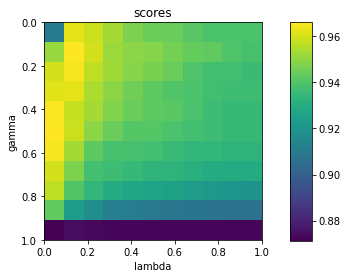

In [223]:
plot_scores(scores_exclusion)

Como se puede observar, por lo general cuanto menor sea el valor del hiperparámetro $\lambda$, mejores resultados se obtiene. Los mejores resultados se obtienen cuando $\gamma$.

Como se puede observar, por lo general cuanto menor sean los valores de los hiperparámetros $\lambda$ y $\gamma$, mejores resultados se obtiene, excepto en el caso de $\lambda = \gamma = 0$.

#### Estimación del hiperparámetro $k$

Como se ha mencionado en la introducción, el Análisis de Componentes Principales selecciona las componentes de máxima varianza, es decir, selecciona las que aportan más información. El hiperparámetro $k$ indica el número de componentes que se seleccionan. Ahora, en vez de estimar el hiperparámetro $k$, vamos a seleccionarlo de otra forma más interesante. Vamos a calcular el valor de $k$ para que la varianza de las $k$ componentes principales sea superior al 99% de la varianza total del conjunto de datos. Vamos a seguir el procedimiento indicado en la sección de Análisis de Componentes Principales de la introducción.

In [54]:
print_cumvar(autoval, X_train.shape[0], 1, 100)

	  1: 0.749930	  2: 0.845959	  3: 0.893969	  4: 0.919388	  5: 0.939298	  6: 0.952600	  7: 0.962024	  8: 0.968061	  9: 0.972753
	 10: 0.976524	 11: 0.979081	 12: 0.981289	 13: 0.983410	 14: 0.985319	 15: 0.986814	 16: 0.988062	 17: 0.989209	 18: 0.990238
	 19: 0.991113	 20: 0.991756	 21: 0.992346	 22: 0.992880	 23: 0.993340	 24: 0.993776	 25: 0.994184	 26: 0.994546	 27: 0.994870
	 28: 0.995189	 29: 0.995434	 30: 0.995661	 31: 0.995884	 32: 0.996088	 33: 0.996269	 34: 0.996447	 35: 0.996620	 36: 0.996777
	 37: 0.996923	 38: 0.997062	 39: 0.997196	 40: 0.997319	 41: 0.997432	 42: 0.997539	 43: 0.997640	 44: 0.997736	 45: 0.997828
	 46: 0.997909	 47: 0.997987	 48: 0.998062	 49: 0.998132	 50: 0.998198	 51: 0.998261	 52: 0.998324	 53: 0.998381	 54: 0.998438
	 55: 0.998490	 56: 0.998541	 57: 0.998590	 58: 0.998637	 59: 0.998682	 60: 0.998726	 61: 0.998767	 62: 0.998807	 63: 0.998845
	 64: 0.998882	 65: 0.998917	 66: 0.998952	 67: 0.998985	 68: 0.999015	 69: 0.999044	 70: 0.999072	 71: 0.99909

Los valores mostrados muestran el índice de la componente, y la varianza acumulada de esa componente y las componentes previas. Como se puede observar, la primera componente proporciona el 74.99% de la varianza del conjunto de datos. Si queremos escoger las $k$ primeras componentes para conservar el 99% de la varianza del conjunto de datos, nos vale con seleccionar 18 componentes. Vamos a confirmar ahora que los resultados con 18 componentes no varían mucho comparados con los de 100 componentes.

In [55]:
# Seleccionamos las 18 primeras componentes
A = autovec[:18]
# Proyectar el conjunto de datos de entrenamiento estandarizado sobre el nuevo espacio
X_train_final = (A @ X_norm.T).T
# Proyectar el conjunto de datos de test sobre el nuevo espacio:
X_test_final = (A @ (X_test - np.mean(X_test, axis=0)).T).T

print("X_train_final:", X_train_final.shape)
print("X_test_final:", X_test_final.shape)

X_train_final: (6238, 18)
X_test_final: (1559, 18)


In [56]:
# Entrenamos y evaluamos el clasificador con los hiperparámetros
scores_exclusion = GridSearchExclusion(X_train_final, y_train, X_test_final, y_test)

print("max_score exclusion:\t\t%.4f" % np.max(scores_exclusion))

Finalizado en 1.715s
max_score exclusion:		0.9140


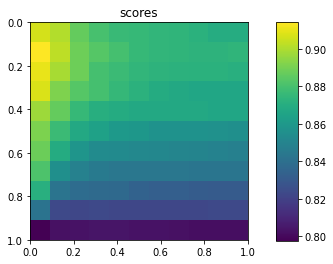

In [57]:
plot_scores(scores_exclusion)

El eje horizontal muestra los valores de $\lambda$, y el vertical los de $\gamma$. 

Como se puede observar, este código se ha ejecutado en unos 5 segundos, mientras que el anterior ha tardado más de 250 segundos (en mi ordenador). Obviamente se debe a la reducción en la dimensionalidad: se ha pasado de manejar matrices de 6238x100 a matrices de 6238x18. La puntuación con 100 componentes es 0.9660, mientras que con 18 componentes es 0.9140. Se ha reducido el tiempo de cómputo en un 97%, sacrificando sólo un 5,2% de precisión. Vamos a probar ahora cuánta precisión se obtiene tomando las $k$ primeras componentes, de forma que se conserva un 99,9% de la varianza total. Viendo los valores de varianzas acumuladas, nos basta con seleccionar las 68 primeras, conservando un 99,9015% de la varianza total. Una de las ventajas del método de Análisis de Componentes Principales es que no es necesario recalcular la matriz de proyección $A$ si se quiere probar con un $k$ distinto. Repetimos los pasos.

In [58]:
# Seleccionamos las 68 primeras componentes
A = autovec[:68]
# Proyectar el conjunto de datos de entrenamiento estandarizado sobre el nuevo espacio
X_train_final = (A @ X_norm.T).T
# Proyectar el conjunto de datos de test sobre el nuevo espacio:
X_test_final = (A @ (X_test - np.mean(X_test, axis=0)).T).T
print("X_train_final:", X_train_final.shape)
print("X_test_final:", X_test_final.shape)

X_train_final: (6238, 68)
X_test_final: (1559, 68)


In [59]:
# Entrenamos y evaluamos el clasificador con los hiperparámetros

# IMPORTANTE: el siguiente fragmento de codigo tarda en ejecutar unos 15 segundos.
#             Los resultados se han precalculado y están guardados en scores_exclusion por si no se quiere ejecutar esta parte.

scores_exclusion = np.array([[0.930725, 0.958948, 0.949968, 0.948044, 0.943554, 0.942271, 0.940346, 0.938422, 0.937139, 0.935215, 0.935215],
                            [0.950609, 0.959589, 0.951892, 0.946761, 0.944836, 0.944836, 0.940988, 0.937781, 0.937139, 0.935856, 0.935215],
                            [0.957665, 0.958948, 0.949326, 0.946119, 0.943554, 0.942271, 0.940988, 0.939064, 0.937139, 0.936498, 0.935856],
                            [0.964080, 0.955741, 0.948044, 0.943554, 0.942271, 0.939705, 0.939064, 0.938422, 0.937781, 0.937139, 0.934573],
                            [0.966645, 0.954458, 0.944836, 0.942271, 0.940988, 0.940346, 0.937781, 0.937781, 0.936498, 0.934573, 0.932649],
                            [0.961514, 0.952534, 0.942271, 0.939064, 0.937139, 0.934573, 0.933932, 0.933291, 0.932008, 0.932008, 0.932008],
                            [0.957665, 0.944836, 0.936498, 0.934573, 0.932649, 0.931366, 0.930725, 0.930083, 0.930083, 0.929442, 0.928801],
                            [0.955099, 0.940346, 0.934573, 0.930725, 0.929442, 0.928159, 0.927518, 0.926235, 0.925593, 0.923669, 0.922386],
                            [0.949968, 0.932008, 0.926235, 0.923028, 0.920462, 0.919179, 0.917896, 0.915972, 0.914047, 0.914047, 0.914047],
                            [0.933932, 0.914689, 0.909557, 0.906992, 0.904426, 0.903143, 0.903143, 0.901860, 0.901219, 0.901219, 0.899936],
                            [0.869147, 0.872996, 0.872354, 0.872354, 0.871713, 0.871713, 0.871713, 0.871713, 0.871713, 0.871713, 0.871713]])

#scores_exclusion = GridSearchExclusion(X_train_final, y_train, X_test_final, y_test)

print("max_score exclusion:\t\t%.4f" % np.max(scores_exclusion))

max_score exclusion:		0.9666


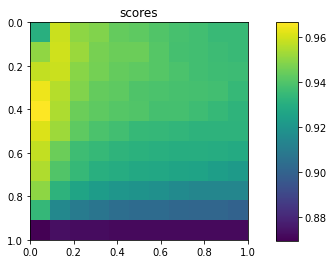

In [60]:
plot_scores(scores_exclusion)

El eje horizontal muestra los valores de $\lambda$, y el vertical los de $\gamma$. Como se ve, los valores de $\gamma$ y $\lambda$ óptimos son $\gamma=0.4$ y $\lambda = 0.0$

Seleccionando las 68 primeras componentes, el porcentaje de la varianza del conjunto de datos que se conserva es 99,9015%. Esta vez se ha ejecutado en 66 segundos, pero la precisión ha sido de 0.9666. Esta precisión es incluso mayor que la que se obtiene con 100 componentes, 0.9660. Esto se debe al fenómeno conocido como *overfitting*. Si se seleccionan todas las componentes (caso estudiado arriba), el clasificador "aprende" de todas y cada una de ellas, el problema es que de las 617 componentes que tiene, la mayoría no proporciona información útil, por tanto influye negativamente en la clasificación de datos. Como se ha visto, con tan solo 18 de las 671 componentes se conserva un 99% de la varianza total, mientras que con 68 se conserva un 99,9%. En este caso, con 68 componentes, se ha obtenido una puntuación mayor que con 100 componentes, lo que indica que el "número ideal de componentes" se sitúa entre 68 y 100. Este valor de $k$ consigue un balance entre conservar la máxima varianza entre clases, pero sin que se produzca *overfitting*.

Cabe destacar que sólamente se han probado los nuevos datos con las combinaciones de los hiperparámetros $\lambda$ y $\gamma$ de la lista `[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]`. La máxima puntuación que se obtenía antes de aplicar el Análisis de Componentes Principales (equivalente a seleccionar todas las componentes) es 0.956. Ahora se ha conseguido una puntuación incluso mayor: 0.9666. Este método no sólo elimina los datos menos importantes que empeoran los resultados, también simplifica el problema, por lo que se ejecuta el algoritmo de clasificación mucho más rápido. 

### **Evaluación de Isolet** tras hacer un **Análisis Discriminante Lineal**

Se toma como base el hiperparámetro que indica número de componentes principales que seleccionamos. Este hiperparámetro indica el número de columnas que tendrá la matriz de proyección $A$ (ver Análisis de Componentes Principales en la introducción).

En esta sección se prueba el clasificador estadístico con todas las combinaciones de hiperparámetros $\gamma$ y $\lambda$ de la lista 0.0, 0.1, 0.2, ..., 1.0. No se prueba con listas más extensas porque tardaría demasiado en ejecutar.

**IMPORTANTE:** HAY QUE EJECUTAR TODAS LAS CELDAS EN ORDEN SECUENCIAL

#### Estimación del hiperparámetro $c$

Como se ha mencionado en la introducción, el Análisis Discriminante Lineal selecciona las componentes que minimizan la varianza dentro de cada clase y maximizan la varianza entre clases, es decir maximiza el Ratio de Fisher. El hiperparámetro $c$ indica el número de componentes que se seleccionan. Vamos a seleccionar este hiperparámetro con el mismo método que en la evaluación de Isolet con Análisis de Componentes Principales. Vamos a calcular el valor de $c$ para que la varianza de (Sw^-1)Sb sea superior al 99% de la varianza total del conjunto de datos.

In [61]:
# Calcular las matrices Sb y Sw (ver apartado de Análisis Discriminante Lineal de la introducción).
n_caracteristicas = X_train.shape[1]
Sw = np.zeros((n_caracteristicas, n_caracteristicas))
Sb = np.zeros((n_caracteristicas, n_caracteristicas))
n_clases = len(np.unique(y_train))
mu_clases = np.mean(X_train, axis=0)
for i in range(n_clases):
    X_clase = X_train[y_train==i]
    Sw = Sw + np.cov(X_clase, rowvar=False)
    Sb = Sb + (len(X_clase) * ((X_clase - mu_clases).T @ (X_clase - mu_clases)))

# Calcular la descomposición espectral de la matriz Sw^-1 Sb
u, autoval, autovec = np.linalg.svd((np.linalg.inv(Sw)@Sb), full_matrices=False) # tarda 68.246s


Calcular las varianzas acumuladas

In [62]:
print_cumvar(autoval, X_train.shape[0], 1, 617)

	  1: 0.729799	  2: 0.866850	  3: 0.903938	  4: 0.937865	  5: 0.952736	  6: 0.964360	  7: 0.972365	  8: 0.977805	  9: 0.982307
	 10: 0.985554	 11: 0.987190	 12: 0.988345	 13: 0.989287	 14: 0.989833	 15: 0.990363	 16: 0.990624	 17: 0.990849	 18: 0.991064
	 19: 0.991236	 20: 0.991383	 21: 0.991489	 22: 0.991582	 23: 0.991656	 24: 0.991728	 25: 0.991777	 26: 0.991792	 27: 0.991807
	 28: 0.991822	 29: 0.991836	 30: 0.991851	 31: 0.991866	 32: 0.991880	 33: 0.991895	 34: 0.991910	 35: 0.991924	 36: 0.991939
	 37: 0.991953	 38: 0.991968	 39: 0.991982	 40: 0.991997	 41: 0.992011	 42: 0.992026	 43: 0.992040	 44: 0.992055	 45: 0.992069
	 46: 0.992084	 47: 0.992098	 48: 0.992113	 49: 0.992127	 50: 0.992142	 51: 0.992156	 52: 0.992171	 53: 0.992185	 54: 0.992200
	 55: 0.992214	 56: 0.992228	 57: 0.992243	 58: 0.992257	 59: 0.992272	 60: 0.992286	 61: 0.992301	 62: 0.992315	 63: 0.992330
	 64: 0.992344	 65: 0.992358	 66: 0.992373	 67: 0.992387	 68: 0.992402	 69: 0.992416	 70: 0.992431	 71: 0.99244

Esta vez es necesario imprimir todos los valores. Si queremos escoger las $c$ primeras componentes para conservar el 99% de la varianza del conjunto de datos, nos vale con seleccionar 15 componentes.

In [63]:
# Seleccionamos las 15 primeras componentes
A = autovec[:15]
# Proyectar el conjunto de datos de entrenamiento sobre el nuevo espacio
X_train_final = (A @ X_train.T).T
# Proyectar el conjunto de datos de test sobre el nuevo espacio:
X_test_final = (A @ X_test.T).T

print("X_train_final:", X_train_final.shape)
print("X_test_final:", X_test_final.shape)

X_train_final: (6238, 15)
X_test_final: (1559, 15)


In [64]:
# Entrenar el clasificador y evaluarlo para cada combinación de lambda y gamma
scores_exclusion = GridSearchExclusion(X_train_final, y_train, X_test_final, y_test)

print("max_score exclusion:\t\t%.4f" % np.max(scores_exclusion))
#print_scores_copy_paste(scores_exclusion)

Finalizado en 1.291s
max_score exclusion:		0.9307


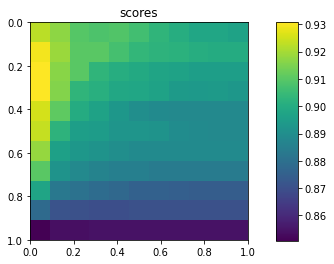

In [65]:
plot_scores(scores_exclusion)

El eje horizontal muestra los valores de $\lambda$, y el vertical los de $\gamma$. Comparando con el ACP, que obtuvo una tasa de aciertos del 91,4%, con el método de ADL obtenemos una tasa de aciertos de 93,07%.

Vamos a probar ahora a escoger las $c$ primeras componentes que conserven el 99,9% de la varianza. Mirando en los valores impresos arriba, el número de componentes que hay que seleccionar es 527. Notese la diferencia con el Análisis de Componentes Principales, el 99% estaba en 18 componentes y el 99,9% en 68; mientras que en el Análisis Discriminante Lineal el 99% está en 15 y el 99,9% está en 527.

In [66]:
# Seleccionamos las 527 primeras componentes
A = autovec[:527]
# Proyectar el conjunto de datos de entrenamiento estandarizado sobre el nuevo espacio
X_train_final = (A @ X_train.T).T
# Proyectar el conjunto de datos de test sobre el nuevo espacio:
X_test_final = (A @ X_test.T).T

print("X_train_final:", X_train_final.shape)
print("X_test_final:", X_test_final.shape)

X_train_final: (6238, 527)
X_test_final: (1559, 527)


In [67]:
# Entrenar el clasificador y evaluarlo para cada combinación de lambda y gamma
# IMPORTANTE: el siguiente fragmento de codigo tarda en ejecutar unos 38 segundos.
#             Los resultados se han precalculado y están guardados en scores_exclusion por si no se quiere ejecutar esta parte.

scores_exclusion = np.array([[0.038486, 0.038486, 0.038486, 0.038486, 0.038486, 0.038486, 0.038486, 0.038486, 0.038486, 0.038486, 0.038486],
                            [0.038486, 0.038486, 0.038486, 0.038486, 0.038486, 0.038486, 0.038486, 0.038486, 0.038486, 0.038486, 0.038486],
                            [0.038486, 0.038486, 0.038486, 0.038486, 0.038486, 0.038486, 0.038486, 0.038486, 0.038486, 0.038486, 0.038486],
                            [0.038486, 0.038486, 0.038486, 0.038486, 0.038486, 0.038486, 0.038486, 0.038486, 0.038486, 0.038486, 0.038486],
                            [0.038486, 0.038486, 0.038486, 0.038486, 0.038486, 0.038486, 0.038486, 0.038486, 0.038486, 0.038486, 0.038486],
                            [0.038486, 0.038486, 0.038486, 0.038486, 0.038486, 0.038486, 0.038486, 0.038486, 0.038486, 0.038486, 0.038486],
                            [0.038486, 0.038486, 0.038486, 0.038486, 0.038486, 0.038486, 0.038486, 0.038486, 0.038486, 0.038486, 0.038486],
                            [0.038486, 0.038486, 0.038486, 0.038486, 0.038486, 0.038486, 0.038486, 0.038486, 0.038486, 0.038486, 0.038486],
                            [0.038486, 0.038486, 0.038486, 0.038486, 0.038486, 0.038486, 0.038486, 0.038486, 0.038486, 0.038486, 0.038486],
                            [0.038486, 0.038486, 0.038486, 0.038486, 0.038486, 0.038486, 0.038486, 0.038486, 0.038486, 0.038486, 0.038486],
                            [0.038486, 0.038486, 0.038486, 0.038486, 0.038486, 0.038486, 0.038486, 0.038486, 0.038486, 0.038486, 0.038486]])

#scores_exclusion = GridSearchExclusion(X_train_final, y_train, X_test_final, y_test)

print("max_score exclusion:\t\t%.4f" % np.max(scores_exclusion))

max_score exclusion:		0.0385


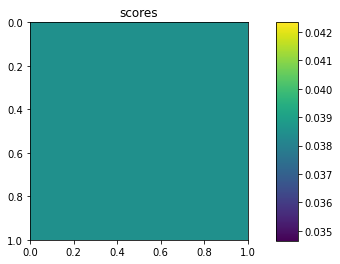

In [68]:
plot_scores(scores_exclusion)

El eje horizontal muestra los valores de $\lambda$, y el vertical los de $\gamma$. Como vemos, los resultados son pésimos. Estamos otra vez en el caso de *overfitting*, en el que se suministran demasiadas dimensiones que no proporcionan información adicional.

### **Evaluación de Isolet** con mezcla de **ACP** y **ADL**

Se analizará primero con APC y ADL, y posteriormente con ADL y ACP. Se tomarán las componentes que contienen el 99,9% de la varianza para la primera fase y de estos se analizará cuántas componentes elegir para conservar el 99% y el 99,9% de la varianza para la segunda fase. 

##### **ACP** -> **ADL**

Para ACP habíamos seleccionado 68 componentes, que mantienen el 99,9% de la varianza.

In [69]:
# Calcular la matriz A
# Calcular la media del conjunto de datos de entrenamiento
X_train_mean = np.mean(X_train, axis=0)

# Estandarizar el conjunto de datos de entrenamiento
X_norm = X_train - X_train_mean

# Calcular la nueva matriz de covarianzas del conjunto de datos estandarizados
X_train_cov = np.cov(X_norm, rowvar=False)

# Calcular la descomposición espectral de la matriz de covarianzas
u, autoval, autovec = np.linalg.svd(X_train_cov, full_matrices=False) # tarda 68.246s

# Construir la matriz de proyección A seleccionando las 68 componentes principales
n_componentes = 68 # hiperparámetro
A = autovec[:n_componentes]

# Proyectar el conjunto de datos de entrenamiento estandarizado sobre el nuevo espacio
X_train_final_ACP = (A @ X_norm.T).T

# Proyectar el conjunto de datos de test sobre el nuevo espacio:
X_test_final_ACP = (A @ (X_test - np.mean(X_test, axis=0)).T).T

print("X_train_final_ACP:", X_train_final_ACP.shape)
print("X_test_final_ACP:", X_test_final_ACP.shape)

X_train_final_ACP: (6238, 68)
X_test_final_ACP: (1559, 68)


Ahora se calculan y visualizan las varianzas acumuladas para estimar el hiperparámetro $c$ de ADL, pero primero hay que calcular las matrices $S_{w}$ y $S_{b}$:

In [70]:
# Calcular las matrices Sb y Sw (ver apartado de Análisis Discriminante Lineal de la introducción).
n_caracteristicas = X_train_final_ACP.shape[1]
Sw = np.zeros((n_caracteristicas, n_caracteristicas))
Sb = np.zeros((n_caracteristicas, n_caracteristicas))
n_clases = len(np.unique(y_train))
mu_clases = np.mean(X_train_final_ACP, axis=0)
for i in range(n_clases):
    X_clase = X_train_final_ACP[y_train==i]
    Sw = Sw + np.cov(X_clase, rowvar=False)
    Sb = Sb + (len(X_clase) * ((X_clase - mu_clases).T @ (X_clase - mu_clases)))

# Calcular la descomposición espectral de la matriz Sw^-1 Sb
u, autoval, autovec = np.linalg.svd((np.linalg.inv(Sw)@Sb), full_matrices=False) # tarda 68.246s


Ahora se pueden visualizar las varianzas acumuladas para el conjunto de datos obtenido de hacer ACP con $k=68$ componentes.

In [71]:
print_cumvar(autoval, X_train.shape[0], 1, 68)

	  1: 0.638590	  2: 0.818469	  3: 0.865391	  4: 0.893118	  5: 0.913279	  6: 0.929994	  7: 0.941599	  8: 0.952724	  9: 0.960716
	 10: 0.965241	 11: 0.967882	 12: 0.970030	 13: 0.971660	 14: 0.973022	 15: 0.974177	 16: 0.975133	 17: 0.976004	 18: 0.976779
	 19: 0.977474	 20: 0.978121	 21: 0.978760	 22: 0.979386	 23: 0.979963	 24: 0.980517	 25: 0.981032	 26: 0.981507	 27: 0.981982
	 28: 0.982457	 29: 0.982932	 30: 0.983407	 31: 0.983882	 32: 0.984357	 33: 0.984831	 34: 0.985306	 35: 0.985781	 36: 0.986256
	 37: 0.986730	 38: 0.987205	 39: 0.987679	 40: 0.988154	 41: 0.988628	 42: 0.989102	 43: 0.989576	 44: 0.990050	 45: 0.990523
	 46: 0.990995	 47: 0.991466	 48: 0.991936	 49: 0.992405	 50: 0.992873	 51: 0.993340	 52: 0.993803	 53: 0.994265	 54: 0.994721
	 55: 0.995175	 56: 0.995628	 57: 0.996078	 58: 0.996512	 59: 0.996939	 60: 0.997364	 61: 0.997776	 62: 0.998177	 63: 0.998561
	 64: 0.998938	 65: 0.999270	 66: 0.999577	 67: 0.999809	 68: 1.000000

Para conservar el 99% de la varianza, hay que seleccionar 44 componentes de la nueva matriz $A$.

In [72]:
# Seleccionamos las 44 primeras componentes
A = autovec[:44]
# Proyectar el conjunto de datos de entrenamiento estandarizado sobre el nuevo espacio
X_train_final_ACP_ADL = (A @ X_train_final_ACP.T).T
# Proyectar el conjunto de datos de test sobre el nuevo espacio:
X_test_final_ACP_ADL = (A @ X_test_final_ACP.T).T

print("X_train_final_ACP_ADL:", X_train_final_ACP_ADL.shape)
print("X_test_final_ACP_ADL:", X_test_final_ACP_ADL.shape)

X_train_final_ACP_ADL: (6238, 44)
X_test_final_ACP_ADL: (1559, 44)


In [73]:
# Entrenar el clasificador y evaluarlo para cada combinación de lambda y gamma
# IMPORTANTE: el siguiente fragmento de codigo tarda en ejecutar unos 7 segundos.
#             Los resultados se han precalculado y están guardados en scores_exclusion por si no se quiere ejecutar esta parte.

scores_exclusion = np.array([[0.933932, 0.953175, 0.940988, 0.937139, 0.934573, 0.933291, 0.932649, 0.932008, 0.931366, 0.930725, 0.929442],
                            [0.950609, 0.950609, 0.940346, 0.935215, 0.933291, 0.932008, 0.932649, 0.931366, 0.931366, 0.930725, 0.926876],
                            [0.953817, 0.946119, 0.940988, 0.936498, 0.933291, 0.932649, 0.931366, 0.928801, 0.927518, 0.924952, 0.924952],
                            [0.954458, 0.944836, 0.938422, 0.934573, 0.932008, 0.930725, 0.930083, 0.926876, 0.926235, 0.924952, 0.924310],
                            [0.953817, 0.944195, 0.935856, 0.933932, 0.929442, 0.927518, 0.924952, 0.924310, 0.924310, 0.924310, 0.924310],
                            [0.953175, 0.939705, 0.932008, 0.929442, 0.928159, 0.926235, 0.924952, 0.924310, 0.924310, 0.924310, 0.923669],
                            [0.950609, 0.932008, 0.930083, 0.926235, 0.924310, 0.923669, 0.923669, 0.922386, 0.921745, 0.921745, 0.921103],
                            [0.947402, 0.932008, 0.925593, 0.923669, 0.921745, 0.919179, 0.918538, 0.918538, 0.917896, 0.917896, 0.917255],
                            [0.940988, 0.921103, 0.917896, 0.916613, 0.915972, 0.914689, 0.913406, 0.913406, 0.911482, 0.911482, 0.910840],
                            [0.922386, 0.908916, 0.903784, 0.903143, 0.903143, 0.900577, 0.900577, 0.900577, 0.900577, 0.900577, 0.899294],
                            [0.881976, 0.881334, 0.883258, 0.883900, 0.883258, 0.883258, 0.883258, 0.883258, 0.883258, 0.883258, 0.883258]])

#scores_exclusion = GridSearchExclusion(X_train_final_ACP_ADL, y_train, X_test_final_ACP_ADL, y_test)

print("max_score exclusion:\t\t%.4f" % np.max(scores_exclusion))

max_score exclusion:		0.9545


En los siguientes gráficos se muestran las puntuaciones del clasificador estadístico regularizado (con el método de clase) para cada valor de los hiperparámetros $\lambda$ y $\gamma$. Se han empleado los datos `X_train_final_ACP_ADL` y `X_test_final_ACP_ADL`, que se han obtenido previamente seleccionando las 44 primeras componentes principales seleccionadas por ADL, de las 68 primeras componentes principales seleccionadas por ACP.

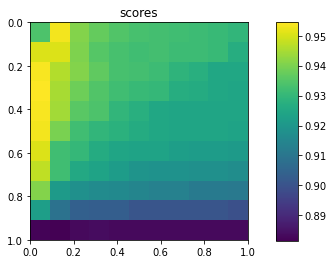

In [74]:
plot_scores(scores_exclusion)

Como se puede observar, por lo general cuanto menor sean los valores de los hiperparámetros $\lambda$ y $\gamma$, mejores resultados se obtiene (sobre todo en el parámetro $\lambda$), excepto en el caso de $\lambda = \gamma = 0$. La máxima puntuación es de 95,45%. Ahora seleccionaremos las componentes correspondientes al 99,9% de la varianza de las 68 componentes seleccionadas con ACP (igual que en el caso de 44 componentes para un 99%, pero esta vez para 99,9%). El número correspondiente es 65 componentes.

In [75]:
# Seleccionamos las 65 primeras componentes
A = autovec[:65]
# Proyectar el conjunto de datos de entrenamiento estandarizado sobre el nuevo espacio
X_train_final_ACP_ADL = (A @ X_train_final_ACP.T).T
# Proyectar el conjunto de datos de test sobre el nuevo espacio:
X_test_final_ACP_ADL = (A @ X_test_final_ACP.T).T

print("X_train_final_ACP_ADL:", X_train_final_ACP_ADL.shape)
print("X_test_final_ACP_ADL:", X_test_final_ACP_ADL.shape)

X_train_final_ACP_ADL: (6238, 65)
X_test_final_ACP_ADL: (1559, 65)


In [76]:
# Entrenar el clasificador y evaluarlo para cada combinación de lambda y gamma
# IMPORTANTE: el siguiente fragmento de codigo tarda en ejecutar unos 14 segundos.
#             Los resultados se han precalculado y están guardados en scores_exclusion por si no se quiere ejecutar esta parte.

scores_exclusion = np.array([[0.933932, 0.954458, 0.948044, 0.940988, 0.936498, 0.936498, 0.935856, 0.934573, 0.935215, 0.933291, 0.932008],
                            [0.949326, 0.956382, 0.948044, 0.942271, 0.939064, 0.937781, 0.935215, 0.935215, 0.934573, 0.933291, 0.931366],
                            [0.955099, 0.957024, 0.949326, 0.944836, 0.940988, 0.937781, 0.935215, 0.933291, 0.933291, 0.932649, 0.932008],
                            [0.960231, 0.954458, 0.945478, 0.941629, 0.938422, 0.935856, 0.933932, 0.933291, 0.932008, 0.931366, 0.930725],
                            [0.962155, 0.953175, 0.944836, 0.938422, 0.936498, 0.934573, 0.934573, 0.933932, 0.932008, 0.931366, 0.930083],
                            [0.958948, 0.948685, 0.940346, 0.935856, 0.935215, 0.934573, 0.932649, 0.931366, 0.930083, 0.929442, 0.928159],
                            [0.958948, 0.944195, 0.935856, 0.933291, 0.931366, 0.929442, 0.928801, 0.926876, 0.925593, 0.924952, 0.924310],
                            [0.955741, 0.937781, 0.933291, 0.930725, 0.927518, 0.924952, 0.923669, 0.921103, 0.919820, 0.919820, 0.919820],
                            [0.951251, 0.930725, 0.923669, 0.921103, 0.918538, 0.917896, 0.915972, 0.915330, 0.914047, 0.913406, 0.912765],
                            [0.929442, 0.912123, 0.905709, 0.905067, 0.902502, 0.901860, 0.901860, 0.901219, 0.899936, 0.899936, 0.900577],
                            [0.870430, 0.874278, 0.873637, 0.872996, 0.872996, 0.872996, 0.873637, 0.873637, 0.873637, 0.873637, 0.873637]])

#scores_exclusion = GridSearchExclusion(X_train_final_ACP_ADL, y_train, X_test_final_ACP_ADL, y_test)

print("max_score exclusion:\t\t%.4f" % np.max(scores_exclusion))

max_score exclusion:		0.9622


En los siguientes gráficos se muestran las puntuaciones del clasificador estadístico regularizado (con el método de clase) para cada valor de los hiperparámetros $\lambda$ y $\gamma$. Se han empleado los datos `X_train_final_ACP_ADL` y `X_test_final_ACP_ADL`, que se han obtenido previamente seleccionando las 65 primeras componentes principales seleccionadas por ADL, de las 68 primeras componentes principales seleccionadas por ACP.

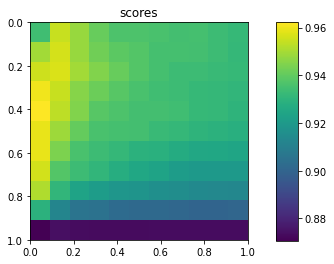

In [77]:
plot_scores(scores_exclusion)

Estamos en un caso similar al anterior, sólo que la major tasa de aciertos obtenida es 96,22%. En el caso anterior (seleccionando las correspondientes al 99% de la varianza de las 68 seleccionadas por ACP) se obtenía una tasa de aciertos del 95,45%. 

##### **ADL** -> **ACP**

Para ADL habíamos seleccionado 527 componentes, que mantienen el 99,9% de la varianza.

In [78]:
# Calcular la matriz A
# Calcular las matrices Sb y Sw (ver apartado de Análisis Discriminante Lineal de la introducción).
n_caracteristicas = X_train.shape[1]
Sw = np.zeros((n_caracteristicas, n_caracteristicas))
Sb = np.zeros((n_caracteristicas, n_caracteristicas))
n_clases = len(np.unique(y_train))
mu_clases = np.mean(X_train, axis=0)
for i in range(n_clases):
    X_clase = X_train[y_train==i]
    Sw = Sw + np.cov(X_clase, rowvar=False)
    Sb = Sb + (len(X_clase) * ((X_clase - mu_clases).T @ (X_clase - mu_clases)))

# Calcular la descomposición espectral de la matriz Sw^-1 Sb
u, autoval, autovec = np.linalg.svd((np.linalg.inv(Sw)@Sb), full_matrices=False) # tarda 68.246s

# Calcular la matriz A, seleccionando 527 componentes
A = autovec[:527]
# Proyectar el conjunto de datos de entrenamiento sobre el nuevo espacio
X_train_final_ADL = (A @ X_train.T).T
# Proyectar el conjunto de datos de test sobre el nuevo espacio:
X_test_final_ADL = (A @ X_test.T).T

print("X_train_final_ADL:", X_train_final_ADL.shape)
print("X_test_final_ADL:", X_test_final_ADL.shape)

X_train_final_ADL: (6238, 527)
X_test_final_ADL: (1559, 527)


Ahora se calculan y visualizan las varianzas acumuladas para estimar el hiperparámetro $k$ de ACP, pero primero hay que calcular la descomposición espectral de la matriz de covarianzas de `X_train_final_ADL`:

In [79]:
# Calcular la media del conjunto de datos de entrenamiento
X_train_mean = np.mean(X_train_final_ADL, axis=0)

# Estandarizar el conjunto de datos de entrenamiento
X_norm = X_train_final_ADL - X_train_mean

# Calcular la nueva matriz de covarianzas del conjunto de datos estandarizados
X_train_cov = np.cov(X_norm, rowvar=False)

# Calcular la descomposición espectral de la matriz de covarianzas
u, autoval, autovec = np.linalg.svd(X_train_cov, full_matrices=False) # tarda 68.246s


Ahora se pueden visualizar las varianzas acumuladas para el conjunto de datos obtenido de hacer ADL con $k=527$ componentes.

In [80]:
print_cumvar(autoval, X_train.shape[0], 1, 100)

	  1: 0.772973	  2: 0.870120	  3: 0.911416	  4: 0.933808	  5: 0.953047	  6: 0.965424	  7: 0.973532	  8: 0.978324	  9: 0.981497
	 10: 0.984010	 11: 0.985972	 12: 0.987566	 13: 0.988882	 14: 0.990072	 15: 0.991160	 16: 0.992032	 17: 0.992810	 18: 0.993523
	 19: 0.994127	 20: 0.994585	 21: 0.994982	 22: 0.995317	 23: 0.995619	 24: 0.995896	 25: 0.996157	 26: 0.996395	 27: 0.996608
	 28: 0.996799	 29: 0.996961	 30: 0.997109	 31: 0.997244	 32: 0.997365	 33: 0.997484	 34: 0.997593	 35: 0.997697	 36: 0.997798
	 37: 0.997891	 38: 0.997975	 39: 0.998056	 40: 0.998131	 41: 0.998201	 42: 0.998265	 43: 0.998327	 44: 0.998387	 45: 0.998443
	 46: 0.998496	 47: 0.998548	 48: 0.998596	 49: 0.998644	 50: 0.998689	 51: 0.998732	 52: 0.998773	 53: 0.998814	 54: 0.998850
	 55: 0.998886	 56: 0.998921	 57: 0.998955	 58: 0.998988	 59: 0.999020	 60: 0.999049	 61: 0.999077	 62: 0.999105	 63: 0.999130
	 64: 0.999156	 65: 0.999180	 66: 0.999204	 67: 0.999227	 68: 0.999249	 69: 0.999270	 70: 0.999290	 71: 0.99931

Para conservar el 99% de la varianza, hay que seleccionar 14 componentes para la nueva matriz $A$.

In [81]:
# Construir la matriz de proyección A seleccionando las n_componentes componentes principales
A = autovec[:14]

# Proyectar el conjunto de datos de entrenamiento estandarizado sobre el nuevo espacio
X_train_final_ADL_ACP = (A @ X_norm.T).T

# Proyectar el conjunto de datos de test sobre el nuevo espacio:
X_test_final_ADL_ACP = (A @ (X_test_final_ADL - np.mean(X_test_final_ADL, axis=0)).T).T

print("X_train_final_ADL_ACP:", X_train_final_ADL_ACP.shape)
print("X_test_final_ADL_ACP:", X_test_final_ADL_ACP.shape)

X_train_final_ADL_ACP: (6238, 14)
X_test_final_ADL_ACP: (1559, 14)


In [82]:
# Entrenar el clasificador y evaluarlo para cada combinación de lambda y gamma
scores_exclusion = GridSearchExclusion(X_train_final_ADL_ACP, y_train, X_test_final_ADL_ACP, y_test)

print("max_score exclusion:\t\t%.4f" % np.max(scores_exclusion))
#print_scores_copy_paste(scores_exclusion)

Finalizado en 1.199s
max_score exclusion:		0.8820


En los siguientes gráficos se muestran las puntuaciones del clasificador estadístico regularizado (con el método de clase) para cada valor de los hiperparámetros $\lambda$ y $\gamma$. Se han empleado los datos `X_train_final_ADL_ACP` y `X_test_final_ADL_ACP`, que se han obtenido previamente seleccionando las 14 primeras componentes principales seleccionadas por ADL, de las 527 primeras componentes principales seleccionadas por ACP.

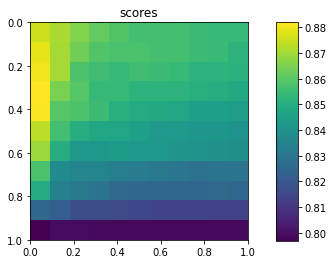

In [83]:
plot_scores(scores_exclusion)

Como se puede observar, por lo general cuanto menor sean los valores de los hiperparámetros $\lambda$ y $\gamma$, mejores resultados se obtiene (sobre todo en el parámetro $\lambda$). La máxima puntuación es de 88,2%. Ahora seleccionaremos las componentes correspondientes al 99,9% de la varianza de las 527 componentes seleccionadas con ADL (igual que en el caso de 14 componentes para un 99%, pero esta vez para 99,9%). El número correspondiente es 59 componentes.

In [84]:
# Seleccionamos las 65 primeras componentes
A = autovec[:59]
# Proyectar el conjunto de datos de entrenamiento estandarizado sobre el nuevo espacio
X_train_final_ADL_ACP = (A @ X_train_final_ADL.T).T
# Proyectar el conjunto de datos de test sobre el nuevo espacio:
X_test_final_ADL_ACP = (A @ X_test_final_ADL.T).T

print("X_train_final_ADL_ACP:", X_train_final_ADL_ACP.shape)
print("X_test_final_ADL_ACP:", X_test_final_ADL_ACP.shape)

X_train_final_ADL_ACP: (6238, 59)
X_test_final_ADL_ACP: (1559, 59)


In [85]:
# Entrenar el clasificador y evaluarlo para cada combinación de lambda y gamma
# IMPORTANTE: el siguiente fragmento de codigo tarda en ejecutar unos 12 segundos.
#             Los resultados se han precalculado y están guardados en scores_exclusion por si no se quiere ejecutar esta parte.

scores_exclusion = np.array([[0.932649, 0.954458, 0.948685, 0.944836, 0.942271, 0.940346, 0.940346, 0.937781, 0.937139, 0.936498, 0.935215],
                            [0.953175, 0.955099, 0.951251, 0.946119, 0.944195, 0.940988, 0.939064, 0.937139, 0.935856, 0.935215, 0.934573],
                            [0.960872, 0.954458, 0.949968, 0.946119, 0.940988, 0.939705, 0.937781, 0.937139, 0.936498, 0.935856, 0.935215],
                            [0.962797, 0.954458, 0.948044, 0.942271, 0.939705, 0.937139, 0.936498, 0.935215, 0.934573, 0.934573, 0.933932],
                            [0.965362, 0.953817, 0.942912, 0.939064, 0.937781, 0.937139, 0.936498, 0.935215, 0.934573, 0.933291, 0.932649],
                            [0.960231, 0.951892, 0.941629, 0.937139, 0.936498, 0.935856, 0.934573, 0.933932, 0.933291, 0.933291, 0.931366],
                            [0.957024, 0.946119, 0.937139, 0.935215, 0.933291, 0.932008, 0.930725, 0.928801, 0.928801, 0.926876, 0.926235],
                            [0.952534, 0.939064, 0.931366, 0.930083, 0.927518, 0.926876, 0.926876, 0.925593, 0.924952, 0.924952, 0.924952],
                            [0.942912, 0.929442, 0.923669, 0.920462, 0.919820, 0.919179, 0.917896, 0.916613, 0.915972, 0.915330, 0.914689],
                            [0.926235, 0.911482, 0.908916, 0.906350, 0.905067, 0.904426, 0.903784, 0.903784, 0.903784, 0.903143, 0.902502],
                            [0.867864, 0.867864, 0.867864, 0.868505, 0.868505, 0.868505, 0.868505, 0.868505, 0.868505, 0.868505, 0.868505]])

#scores_exclusion = GridSearchExclusion(X_train_final_ADL_ACP, y_train, X_test_final_ADL_ACP, y_test)

print("max_score exclusion:\t\t%.4f" % np.max(scores_exclusion))

max_score exclusion:		0.9654


En los siguientes gráficos se muestran las puntuaciones del clasificador estadístico regularizado (con el método de clase) para cada valor de los hiperparámetros $\lambda$ y $\gamma$. Se han empleado los datos `X_train_final_ADL_ACP` y `X_test_final_ADL_ACP`, que se han obtenido previamente seleccionando las 59 primeras componentes principales seleccionadas por ACP, de las 527 primeras componentes principales seleccionadas por ADL.

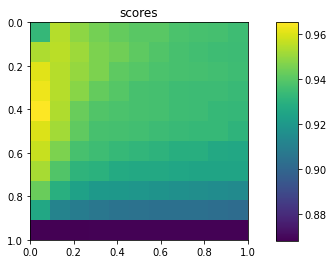

In [86]:
plot_scores(scores_exclusion)

Estamos en un caso similar al anterior, sólo que la major tasa de aciertos obtenida es 96,54%. En el caso anterior (seleccionando las correspondientes al 99% de la varianza de las 527 seleccionadas por ADL) se obtenía una tasa de aciertos del 88,20%. 

***

##### **Resultados de los experimentos con la base de datos Isolet:**

En los casos en los que se prueba primero ACP y luego ADL (y viceversa), de la "primera fase" se seleccionan las componentes correspondientes que conservan el 99,9% de la varianza. También se indican (cuando corresponde) los hiperparámetros $\lambda$ y $\gamma$ que mejores resultados dan. Tanto en ACP como en ADL, se emplea el clasificador estadístico regularizado (nuestra implementación).

| Técnica empleada | nº de componentes seleccionadas | nº de componentes totales| proporción de varianza conservado | Tasa de aciertos (por exclusion) | gamma | lambda |
| --- | --- | --- | --- | --- | --- | --- |
| Clasificador distancia euclídea | - | 617 | 1.00 | 0.8743 | - | - |
||||||||
| Estadístico regularizado de sklearn   | - | - | 1.0 | 0.956 | 0.23 | - |
||||||||
| Estadístico regularizado con ACP          | 100 | 617 | 0.999572 | 0.9660 | 0.4 | 0 |
| Estadístico regularizado con ACP (99%)   | 18 | 617 | 0.990238 | 0.9140 | 0.2 | 0 |
| Estadístico regularizado con ACP (99,9%)  | 68 | 617 | 0.999015 | 0.9666 | 0.4 | 0 |
||||||||
| Estadístico regularizado con ADL (99%)   | 15 | 617 | 0.990363 | 0.9307 | 0.3 | 0 |
| Estadístico regularizado con ADL (99,9%) | 527 | 617 | 0.999003 | 0.0385 | 0 | 0 |
||||||||
| Est. reg. con ACP y ADL (99%)  | 44 | 68 | 0.990050 | 0.9545 | 0.3 | 0 |
| Est. reg. con ACP y ADL (99,9%)| 65 | 68 | 0.999270 | 0.9622 | 0.4 | 0 |
||||||||
| Est. reg. con ADL y ACP (99%)  | 14 | 527 | 0.990072 | 0.8820 | 0.3 | 0 |
| Est. reg. con ADL y ACP (99,9%)| 59 | 527 | 0.999020 | 0.9654 | 0.4 | 0 |


Como se puede observar, la mejor tasa de aciertos que hemos conseguido en la base de datos Isolet, es de 96,66%. Este resultado se obtiene seleccionando las 68 componentes principales más importantes, que conservan un 99,9015% de la varianza total de los datos, y con hiperparámetros $\gamma=0.4$ y $\lambda=0$.

El motivo por el que no conseguimos que la tasa de aciertos aumente más es porque la base de datos presenta muchos datos atípicos. Vamos a visualziar los diagramas de cajas de los datos de las clases 0 y 1. Se muestran las 15 primeras componentes porque el total (617) son demasiadas para visualizar en una gráfica.

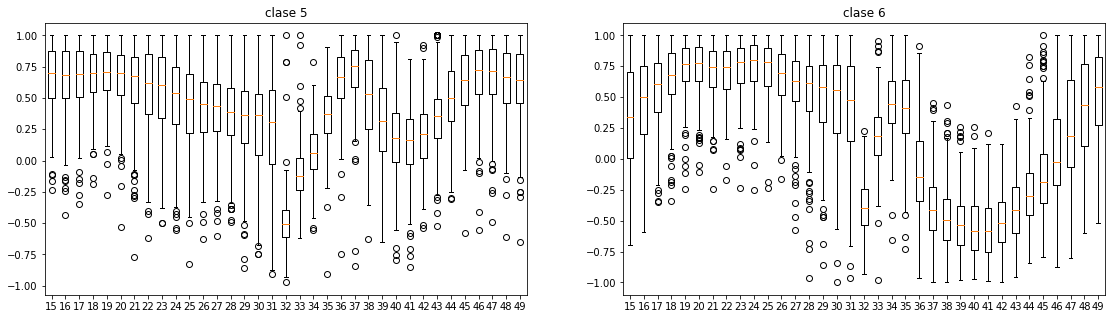

In [142]:
# visualizar las [start:end] componentes de las clases clase1 y clase2
start = 15
end = 50
clase1 = 5
clase2 = 6

fig = plt.figure(figsize=(19, 5))
ax = fig.add_subplot(121)
bp = ax.boxplot(X[y==clase1][:,start:end])
labels = ax.set_xticklabels(list(range(start, end)))
title = ax.set_title('clase %d' % clase1)

ax = fig.add_subplot(122)
bp = ax.boxplot(X[y==clase2][:,start:end])
labels = ax.set_xticklabels(list(range(start, end)))
title = ax.set_title('clase %d' % clase2)

Como se puede observar, algunas de las componentes (dimensiones del vector X, sin reducción de dimensiones) presentan una gran cantidad de datos atípicos: la 13, la 20, etc. También se puede visualizar la similitud entre algunas de las componentes, por ejemplo la 23 y la 25 son muy parecidas. Estas componentes muy parecidas son las que causaban el *overfitting*.

# **Caras**

In [169]:
import logging
import matplotlib.pyplot as plt
import numpy as np
from time import time
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC


lfw_people = fetch_lfw_people(min_faces_per_person=73, resize=0.5)

n_samples, h, w = lfw_people.images.shape

X = lfw_people.data
n_features = X.shape[1]

y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Tamaño total del dataset:")
print(f"n_samples: {n_samples}, hxw: {h} x {w}")
print(f"Numero de caracteristicas: {n_features}, actually {h} x {w} = {h*w}")
print(f"Numero de clases: {n_classes}, nombres: {target_names}")


Tamaño total del dataset:
n_samples: 1217, hxw: 62 x 47
Numero de caracteristicas: 2914, actually 62 x 47 = 2914
Numero de clases: 6, nombres: ['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Tony Blair']


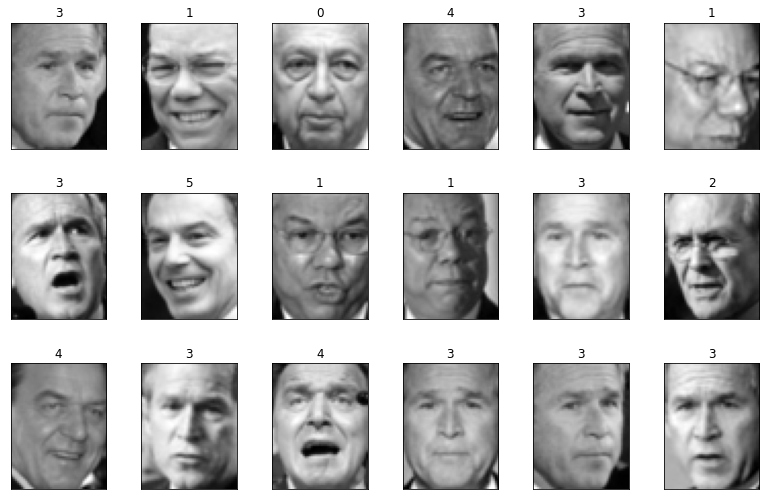

In [170]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())
plot_gallery(X, list(y), h, w, n_row=3, n_col=6)

In [171]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Estadisticas de los datos:")
print(f"Numero de datos de entrenamiento: {X_train.shape[0]}")
print(f"Numero de datos de test: {X_test.shape[0]}")

Estadisticas de los datos:
Numero de datos de entrenamiento: 973
Numero de datos de test: 244


In [179]:
# PCA

n_components = 314

t0 = time()

# Paso 1: hacer la media del conjunto de datos de entrenamiento
X_train_mean = np.mean(X_train, axis=0)


# Paso 2: estandarizar el conjunto de datos de entrenamiento
X_norm = X_train - X_train_mean

print("X_train.shape: ", X_train.shape)

# Paso 3: calcular la nueva matriz de covarianzas del conjunto de datos estandarizados
X_train_cov = np.cov(X_norm, rowvar=False)



# Paso 4: calcular la descomposición espectral de la matriz de covarianzas
u, autoval, autovec = np.linalg.svd(X_train_cov, full_matrices=False) # tarda 68.246s


X_train.shape:  (973, 2914)


In [180]:
print_cumvar(autoval, X_train.shape[0], 1, 300)


	  1: 0.437699	  2: 0.774115	  3: 0.847871	  4: 0.897231	  5: 0.933415	  6: 0.946721	  7: 0.955599	  8: 0.962144	  9: 0.968120
	 10: 0.973348	 11: 0.977113	 12: 0.980060	 13: 0.982321	 14: 0.984007	 15: 0.985498	 16: 0.986951	 17: 0.988166	 18: 0.989260
	 19: 0.990205	 20: 0.990982	 21: 0.991685	 22: 0.992330	 23: 0.992923	 24: 0.993434	 25: 0.993864	 26: 0.994263	 27: 0.994629
	 28: 0.994970	 29: 0.995290	 30: 0.995566	 31: 0.995793	 32: 0.996007	 33: 0.996211	 34: 0.996401	 35: 0.996584	 36: 0.996755
	 37: 0.996908	 38: 0.997047	 39: 0.997172	 40: 0.997291	 41: 0.997405	 42: 0.997517	 43: 0.997619	 44: 0.997714	 45: 0.997805
	 46: 0.997893	 47: 0.997977	 48: 0.998053	 49: 0.998124	 50: 0.998190	 51: 0.998255	 52: 0.998316	 53: 0.998374	 54: 0.998431
	 55: 0.998482	 56: 0.998532	 57: 0.998579	 58: 0.998625	 59: 0.998670	 60: 0.998711	 61: 0.998752	 62: 0.998791	 63: 0.998828
	 64: 0.998865	 65: 0.998900	 66: 0.998935	 67: 0.998969	 68: 0.999001	 69: 0.999032	 70: 0.999061	 71: 0.99908

In [181]:


# Paso 5: construir la matriz de proyección A seleccionando las n_componentes componentes principales
A = autovec[:n_components]

print("A_pca.shape: ", A.shape)

# Paso 6: proyectar el conjunto de datos de entrenamiento estandarizado sobre el nuevo espacio
X_train_pca = (A @ (X_train - np.mean(X_train, axis=0)).T).T

print("X_train_pca:", X_train_pca.shape)

# Paso 7: proyectar el conjunto de datos de test sobre el nuevo espacio:
X_test_pca = (A @ (X_test - np.mean(X_test, axis=0)).T).T

print("X_test_pca:", X_test_pca.shape)

eigenfaces2 = A.reshape((n_components,h,w))

print("PCA done in %0.3fs" % (time() - t0))

#LDA
t0 = time()

Sw = np.zeros((X_train_pca.shape[1], X_train_pca.shape[1]))
Sb = np.zeros((X_train_pca.shape[1], X_train_pca.shape[1]))
n_clases = len(np.unique(y_train))
mu_clases = np.mean(X_train_pca, axis=0)
for i in range(n_clases):
    X_clase = X_train_pca[y_train==i]
    Sw = Sw + np.cov(X_clase, rowvar=False)
    Sb = Sb + (len(X_clase) * ((X_clase - mu_clases).T @ (X_clase - mu_clases)))

# Calcular la descomposición espectral de la matriz Sw^-1 Sb
u, autoval, autovec = np.linalg.svd((np.linalg.inv(Sw)@Sb), full_matrices=False) 


A_pca.shape:  (314, 2914)
X_train_pca: (973, 314)
X_test_pca: (244, 314)
PCA done in 4.807s


In [175]:
print_cumvar(autoval, X_train.shape[0], 1, 314)

	  1: 0.196231	  2: 0.333758	  3: 0.422005	  4: 0.472533	  5: 0.515780	  6: 0.550764	  7: 0.574190	  8: 0.597305	  9: 0.617105
	 10: 0.635090	 11: 0.652164	 12: 0.667595	 13: 0.681168	 14: 0.693928	 15: 0.705224	 16: 0.715623	 17: 0.725895	 18: 0.734513
	 19: 0.742696	 20: 0.750394	 21: 0.757728	 22: 0.764852	 23: 0.771649	 24: 0.778350	 25: 0.784561	 26: 0.790715	 27: 0.796594
	 28: 0.802305	 29: 0.807606	 30: 0.812838	 31: 0.817959	 32: 0.822928	 33: 0.827766	 34: 0.832477	 35: 0.836912	 36: 0.841304
	 37: 0.845623	 38: 0.849620	 39: 0.853552	 40: 0.857331	 41: 0.861057	 42: 0.864702	 43: 0.868205	 44: 0.871627	 45: 0.874946
	 46: 0.878209	 47: 0.881405	 48: 0.884554	 49: 0.887650	 50: 0.890678	 51: 0.893646	 52: 0.896526	 53: 0.899180	 54: 0.901765
	 55: 0.904250	 56: 0.906659	 57: 0.909043	 58: 0.911343	 59: 0.913617	 60: 0.915804	 61: 0.917952	 62: 0.920078	 63: 0.922159
	 64: 0.924180	 65: 0.926146	 66: 0.928039	 67: 0.929894	 68: 0.931703	 69: 0.933460	 70: 0.935205	 71: 0.93690

In [182]:
n_components = 100
A = autovec[:n_components]

print("A_lda.shape:", A.shape)

X_train_lda = (A @ X_train_pca.T).T

print("X_train_lda: ", X_train_lda.shape)

# Paso 7: proyectar el conjunto de datos de test sobre el nuevo espacio:
X_test_lda = (A @ X_test_pca.T).T

#eigenfaces2 = A.reshape((n_components,h,w))
print("LDA done in %0.3fs" % (time() - t0))

A_lda.shape: (100, 314)
X_train_lda:  (973, 100)
LDA done in 11.189s


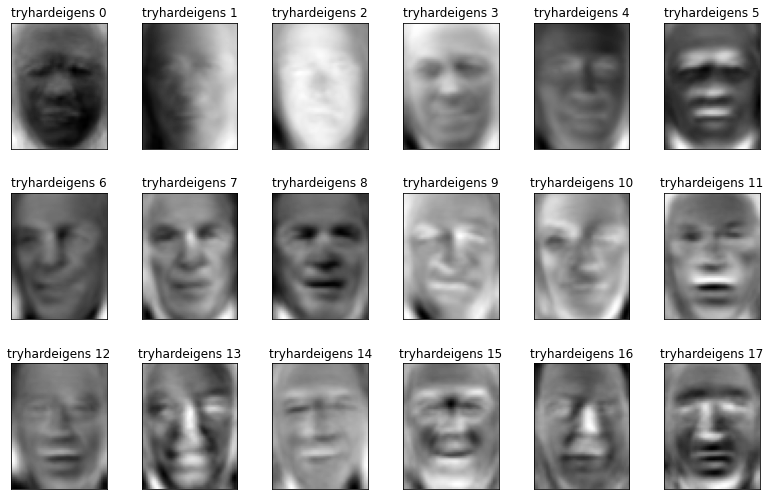

In [187]:

#eigenface_titles1 = ["eigenface PCA %d" % i for i in range(eigenfaces1.shape[0])]
#plot_gallery(eigenfaces1, eigenface_titles1, h, w, n_row=3, n_col=6)
#plt.show()

eigenface_titles2 = ["tryhardeigens %d" % i for i in range(eigenfaces2.shape[0])]
plot_gallery(eigenfaces2, eigenface_titles2, h, w, n_row=3, n_col=6)
plt.show()


Predicting people's names on the test set
done in 0.001s
y_test: (244,)
y_pred: (244,)
                   precision    recall  f1-score   support

     Ariel Sharon       0.12      0.38      0.19         8
     Colin Powell       0.40      0.34      0.37        61
  Donald Rumsfeld       0.47      0.27      0.34        26
    George W Bush       0.62      0.49      0.55       103
Gerhard Schroeder       0.28      0.44      0.34        18
       Tony Blair       0.28      0.43      0.34        28

         accuracy                           0.41       244
        macro avg       0.36      0.39      0.35       244
     weighted avg       0.47      0.41      0.43       244

[[ 3  2  2  1  0  0]
 [13 21  0 15  5  7]
 [ 2  2  7  4  4  7]
 [ 3 24  6 50  9 11]
 [ 1  0  0  3  8  6]
 [ 2  4  0  7  3 12]]


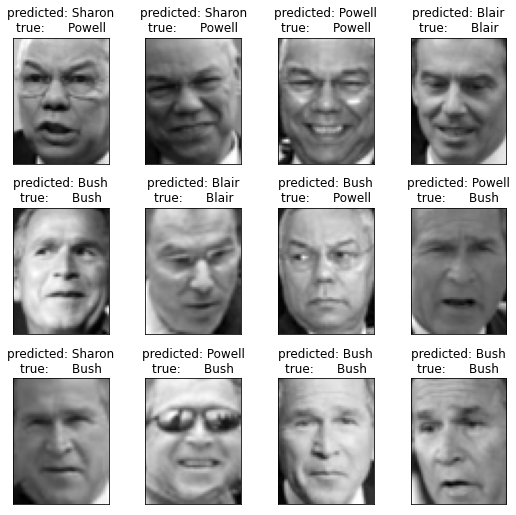

In [178]:
print("Predicting people's names on the test set")
t0 = time()
clf = ClassifEuclid(np.unique(y_train))
clf = clf.fit(X_train_lda, y_train)
y_pred = clf.predict(X_test_lda)
print("done in %0.3fs" % (time() - t0))

print("y_test:", y_test.shape)
print("y_pred:", y_pred.shape)

print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(" ", 1)[-1]
    true_name = target_names[y_test[i]].rsplit(" ", 1)[-1]
    return "predicted: %s\ntrue:      %s" % (pred_name, true_name)
prediction_titles = [title(y_pred, y_test, target_names, i) for i in range(y_pred.shape[0])]
plot_gallery(X_test, prediction_titles, h, w)